# Met Office Public Data Exploration

In this notebook, data from public met office sources is programatically downloaded where possible and explored through various plots. The prerequisite for this sort of exploration of services (but not for this notebook exactly) is: Create an account on DataHub, choose a "pricing" plan for both atmospheric and site specific services on DataHub, create desired atmospheric orders within the DataHub account, place your required API information (order names + client secrets and ids) in environment variables; Create an account on WOW, find desired sites and download site CSV data using the export function with a desired time selection (which export only appears once logged in) in the tables tab within the specific site view; Create an environment containing the desired packages for the exploration.

## Contents

In this notebook specifically, some ideas around the data are presented:

- Download All Self-Defined Orders Using a Subprocess Call to the Provided DataHub Download File `cda_download.py`
- Explore DataHub Data
  - Single Level Atmospheric Plotting
    - With Xarray
    - With Iris
  - Mutli Level Atmospheric Plotting
    - Load Data, Show Metadata
    - Single Layer Plot From Multi Level Data
    - Conversion of Units with Iris
    - Plotted Example of Desired vs Actual Closest Datapoint
    - Height Profile of Data at Fixed Latitude
    - Plot of Actual Datapoint in Gridded Data
      - Height Profile
      - Topdown
    - Show of Temperature at a Single Datapoint (Temperature Column)
  - Site Specific Data Exploration
    - Getting the Data (Current Site Specific Forecast for Exeter)
    - Plotting Two Temperatures (Feels Like, and Screen Temperature) from the Returned Data over the Entire Returned Forecast (Daylong Hourly Forecast)
- Explore Wow Data
  - Single Site
    - Load in Pre-Downloaded Data
    - Format and Explore the Data
      - Show Data Issue: Missing Observations
    - Plot the Data with Rolling Mean for Averages (which is an incorrect implementation due to missing data)
  - Multi Site
    - Load and Merge Data
      - Ensure no Duplicate Data has been Loaded
    - Plot Multi Site Information
    - Prune Data to Leave Desired Data
    - Plot Desired Data as a Whole (Messy)
    - Separate Data by Month per Site
    - Plot All Sites on a Separate plot for each Month (Cleaner)

In [1]:
# import required packages
import datetime
import glob
import json
import subprocess

import cartopy.crs as ccrs
import cfgrib
import iris
import iris.quickplot as qplt
import iris_grib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import xarray as xr

# clear cell outputs when private API keys are displayed
from IPython.display import clear_output

In [2]:
# define notebook settings
HIDE_SECRET_OUTPUT = True  # clears anytime an API key is shown in cell output
# order number is user specific so is stored in env variable,

# displays the full return of a site specific request json
SHOW_SITE_JSON_REQUEST_DATA = False

For this notebook, a .env file is defined in order to abstract away keys personal to the user. Here is an example of what the .env file looks like:

```
ATMOSPHERIC_CLIENT_ID=xxxxxxxxxxxxxxxxxxxxxx
ATMOSPHERIC_CLIENT_SECRET=xxxxxxxxxxxxxxxxxxxxxx
SOME_OTHER_ENV_VAR=2gt2t1t2t7224pZ/*321
```

Due to how the file is read without a common package such as `dotenv` the .env file expecting no comments, nor an in-file informational header.

In [3]:
# read environment file
env_vars = {}

with open(".env") as f:
    for line in f:
        key, value = line.strip().split("=", 1)
        env_vars[key] = value

print(env_vars)
if HIDE_SECRET_OUTPUT:
    clear_output()

In [4]:
# load environment variables
ATMO_ID = env_vars["ATMOSPHERIC_CLIENT_ID"]
ATMO_SECRET = env_vars["ATMOSPHERIC_CLIENT_SECRET"]
SITE_ID = env_vars["SITE_SPECIFIC_CLIENT_ID"]
SITE_SECRET = env_vars["SITE_SPECIFIC_CLIENT_SECRET"]
MULTI_ORDER = env_vars["MULTI_LEVEL_ATMOSPHERIC_ORDER"]
SINGLE_ORDER = env_vars["SINGLE_LEVEL_ATMOSPHERIC_ORDER"]

## Download All Self-Defined Orders Using a Subprocess Call to the Provided DataHub Download File `cda_download.py`

To do this, define the necessary headers for the API call, then run subprocess for the cda_download file which is located in the same directory

In [5]:
# get the data from cda download
headers = {
    "X-IBM-Client-Id": ATMO_ID,
    "X-IBM-Client-Secret": ATMO_SECRET,
}

orders = [MULTI_ORDER, SINGLE_ORDER]  # my own orders, defined in env file
order_str = ""
for o in orders:
    order_str += o + ","
order_str = order_str[:-1]  # remove trailing ','

cda_headers = {
    "-u": "https://api-metoffice.apiconnect.ibmcloud.com/1.0.0",
    "-c": headers["X-IBM-Client-Id"],
    "-s": headers["X-IBM-Client-Secret"],
    "-o": order_str,
}

In [6]:
# view runs available to each order
request_results_list = []
for order in orders:
    request_url_string = cda_headers["-u"] + "/orders/" + order + "/latest"
    request = requests.get(request_url_string, headers=headers)
    request_results_list.append(request)

get all available requests (not just latest) with: <br>
`r = requests.get('https://api-metoffice.apiconnect.ibmcloud.com/1.0.0/runs?sort=RUN', headers=headers)`

In [7]:
# display the results of the run search
print("Response codes from requests:", request_results_list)

print("Response content:")
for r in request_results_list:
    content = r.json()
    order_details = content["orderDetails"]["order"]
    number_of_files_available = len(content["orderDetails"]["files"])
    print(json.dumps(order_details, indent=4))
    print("files:", json.dumps(number_of_files_available, indent=4), "\n")

Response codes from requests: [<Response [200]>, <Response [200]>]
Response content:
{
    "orderId": "o093919734016",
    "name": "O093919734016",
    "modelId": "mo-global",
    "format": "GRIB2"
}
files: 22 

{
    "orderId": "o154205129003",
    "name": "O154205129003",
    "modelId": "mo-uk",
    "format": "GRIB2"
}
files: 2 



In [8]:
# convert cda_headers to list inputtable to subprocess
cda_items = cda_headers.items()
cda_download_arguments = [item for tuples in cda_items for item in tuples]
print("Headers flattened:", cda_download_arguments)
if HIDE_SECRET_OUTPUT:
    clear_output()

In [9]:
# concatenate all elements of the subprocess call into one list
python_script_arguments = ["python3", "cda_download.py"]
additional_flags = [
    "-d",  # -d = add a root directory with the date to the order downloads,
    "-v",  # -v = make the script verbose
]
subprocess_to_run = python_script_arguments + cda_download_arguments + additional_flags
print(subprocess_to_run)
if HIDE_SECRET_OUTPUT:
    clear_output()

example of equivalent command line usage of cda_download (replacing xxx...xxx with your own API keys / Order IDs):

```bash
$ python3 cda_download.py -u https://api-metoffice.apiconnect.ibmcloud.com/1.0.0 -c xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx -s xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx -o xxxxxxxxxxxxx -d -v
```

In [10]:
# run the subprocess
subprocess.run(subprocess_to_run)
print("\nSubprocess end!")
# on success, in the directory contains a folder 'downloaded' with orders

Download Orders
From the orders to process we have the following model list from active orders:  ['mo-global', 'mo-uk']
Processing: o093919734016
Plan and limit : name=free-plan,1000;
Remaining calls: name=free-plan,928;
    Starting downloads
    Total Files: 11 Total time taken: 157.47s Total Size: 1549757 Workers: 4

    Created summary: results/summary-o093919734016-31-Aug-2022-17-38-58.txt
Processing: o154205129003
Plan and limit : name=free-plan,1000;
Remaining calls: name=free-plan,915;
    Starting downloads
    Total Files: 1 Total time taken: 28.21s Total Size: 436289 Workers: 4

    Created summary: results/summary-o154205129003-31-Aug-2022-17-38-58.txt
All file downloads have been attempted.

Subprocess end!


## Explore Datahub Data

In [11]:
# hard-code some orders that we know contain specific data, and plot them
single_level_temperature_order_example_folder = "o154205129003"
multi_level_temperature_order_example_folder = "o093919734016"
order_time_selection = "00"  # as per my own order definitions for the example

### Single level temperature plots

In [12]:
# get paths of downloaded files in downloaded folder
path_pattern_string = (
    "downloaded/"
    + single_level_temperature_order_example_folder
    + "_"
    + order_time_selection
    + "/*.grib2"
)
downloaded_path = glob.glob(path_pattern_string)
print(downloaded_path)

['downloaded/o154205129003_00/agl_temperature_1.5_+00_0.grib2']


#### With Xarray

In [13]:
# load the most recent data file into an xarray dataset
ds = xr.open_dataset(downloaded_path[0], engine="cfgrib")

In [14]:
# print xarray metadata
print(ds)

<xarray.Dataset>
Dimensions:            (y: 639, x: 455)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    t2m                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          5
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2022-08-31T17:42 GRIB to CDM+CF via cfgrib-0.9.1...


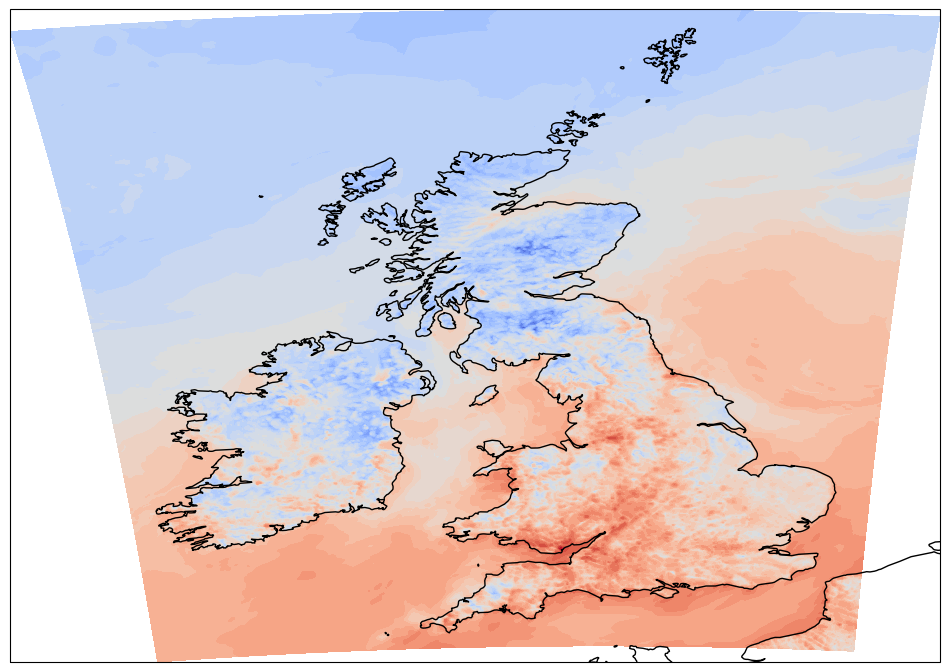

In [15]:
# plot the xarray data
proj = ccrs.PlateCarree()  # cartopy projection
fig = plt.figure(figsize=(12, 12))  # size of plot
axes = plt.axes(projection=proj)  # plot transform
plt.contourf(
    ds["longitude"].data,
    ds["latitude"].data,
    ds["t2m"],  # temperature data
    transform=ccrs.PlateCarree(),  # data transform
    levels=30,  # number of contour bins
    cmap=plt.cm.coolwarm,  # color scheme for heatmap
)
axes.coastlines()  # show maplines

#### With Iris

In [16]:
# load the cube in iris
iris_cubedata = iris.load_cubes(downloaded_path[0])

In [17]:
# show metadata of the cubelist
iris_cubedata

[<iris 'Cube' of air_temperature / (K) (projection_y_coordinate: 639; projection_x_coordinate: 455)>]

In [18]:
# pick the temperature cube out of the loaded cubelist (only cube in the cubelist)
cube = iris_cubedata[0]

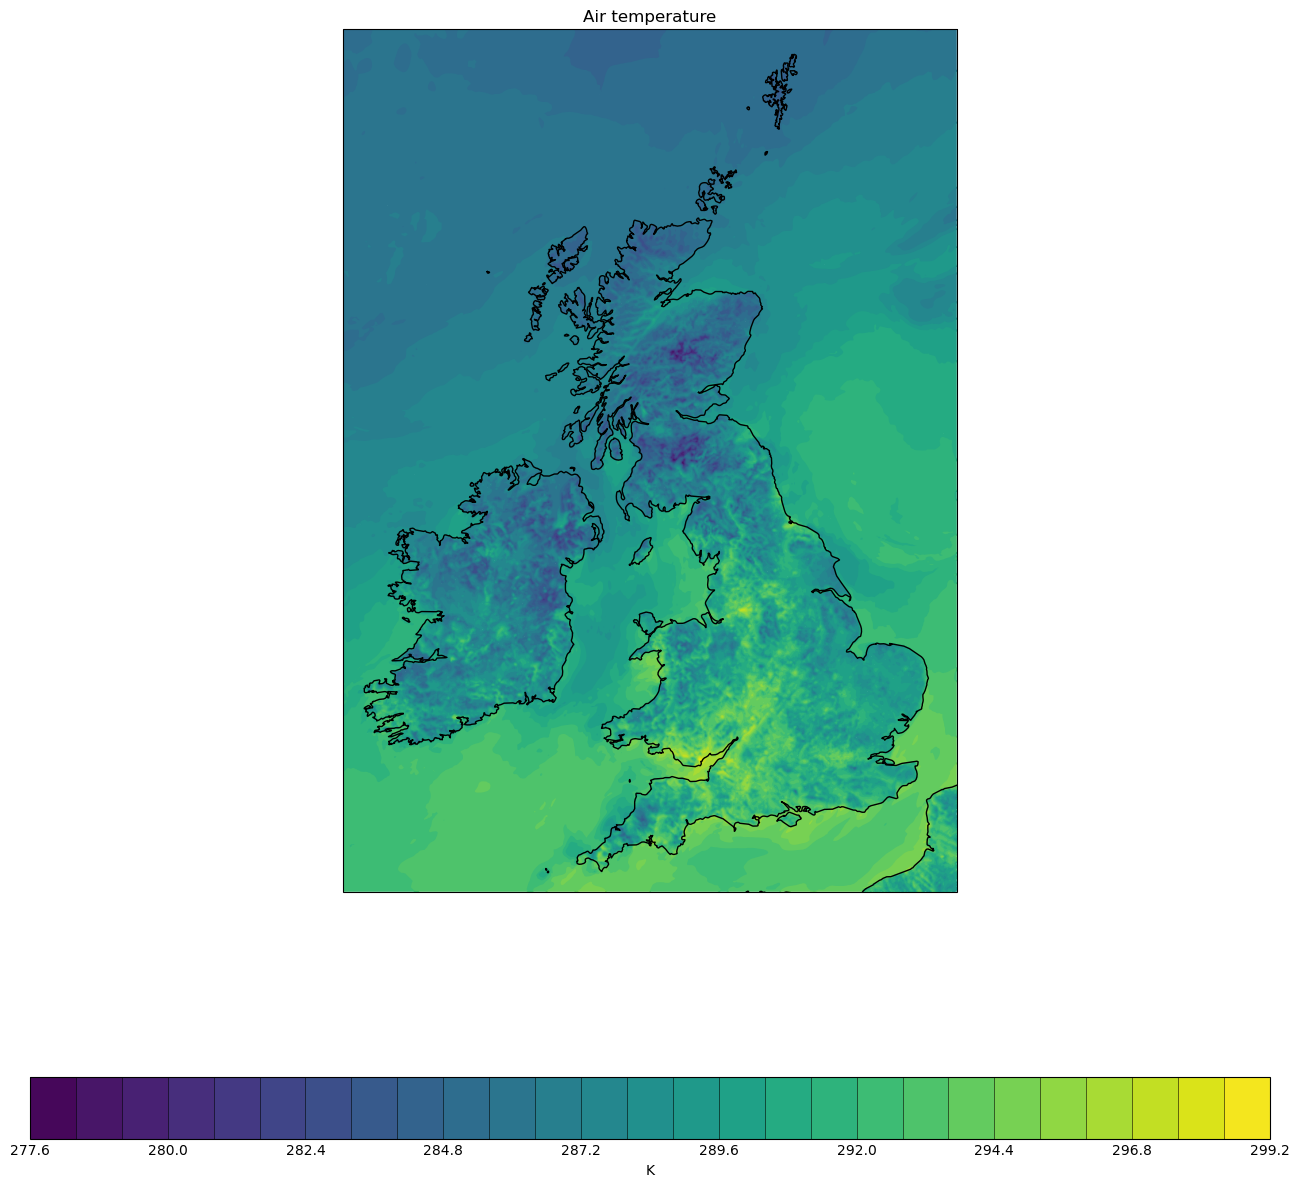

In [19]:
# plot the iris data
plt.figure(figsize=(16, 16))
qplt.contourf(cube, levels=30)
plt.gca().coastlines()  # different way of coastline display, as per iris documentation

plt.show()

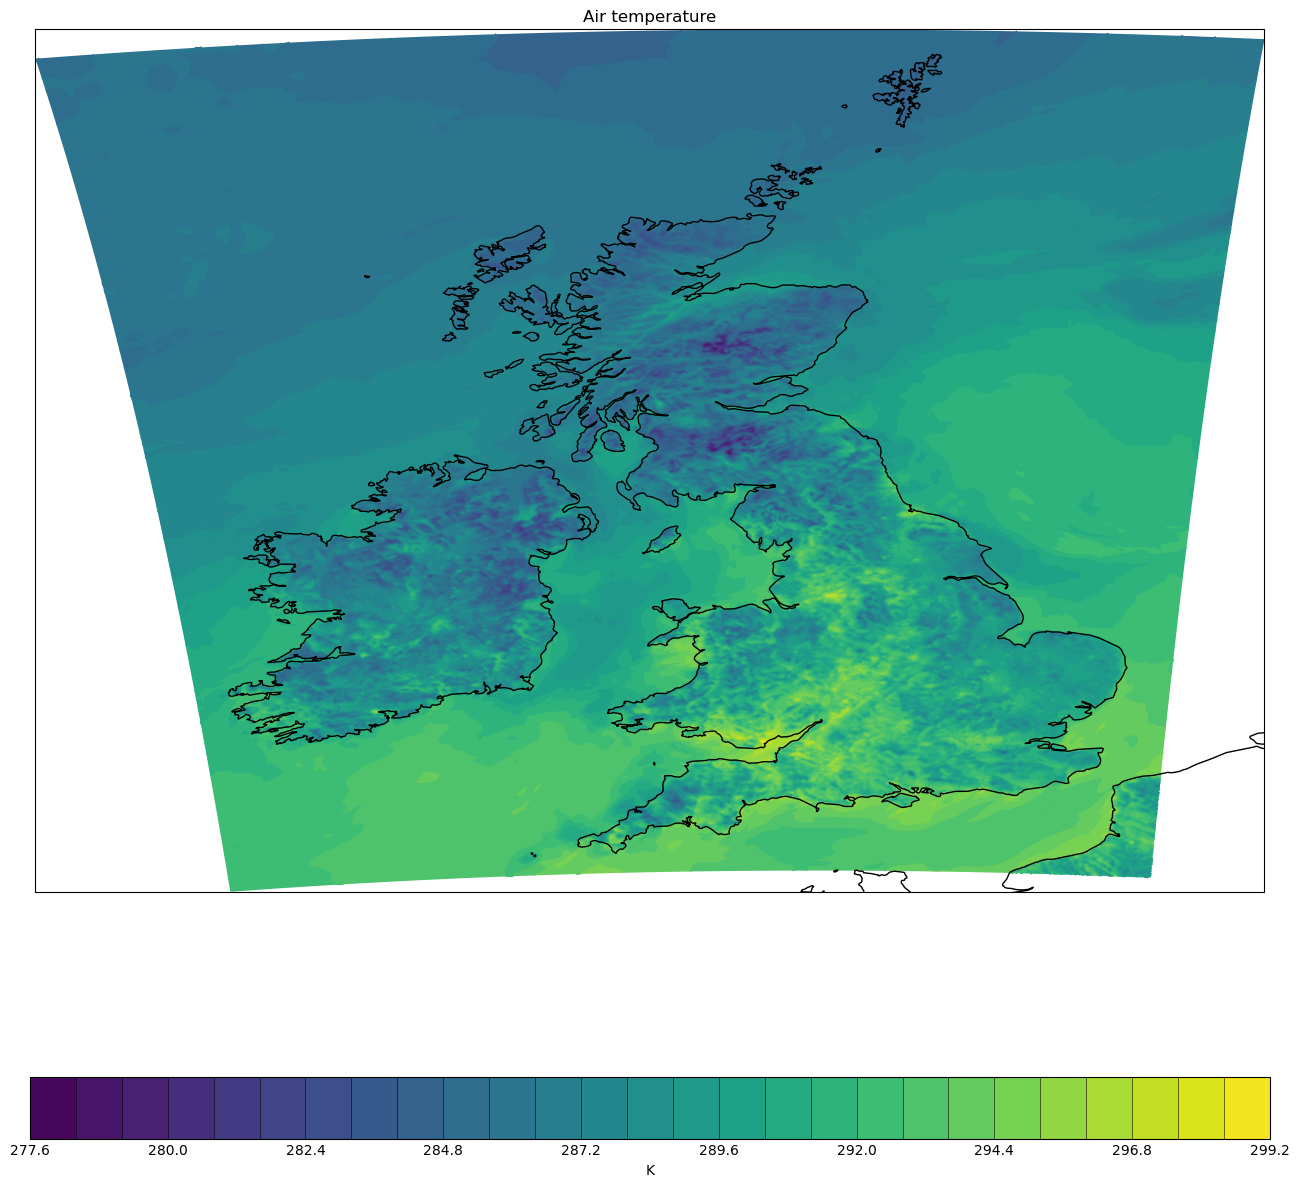

In [20]:
# or to mimic the plot generated by xarray, send the xarray data to iris
iris_cube_from_xarray = ds["t2m"].to_iris()
plt.figure(figsize=(16, 16))
qplt.contourf(iris_cube_from_xarray, levels=30)
plt.gca().coastlines()

plt.show()

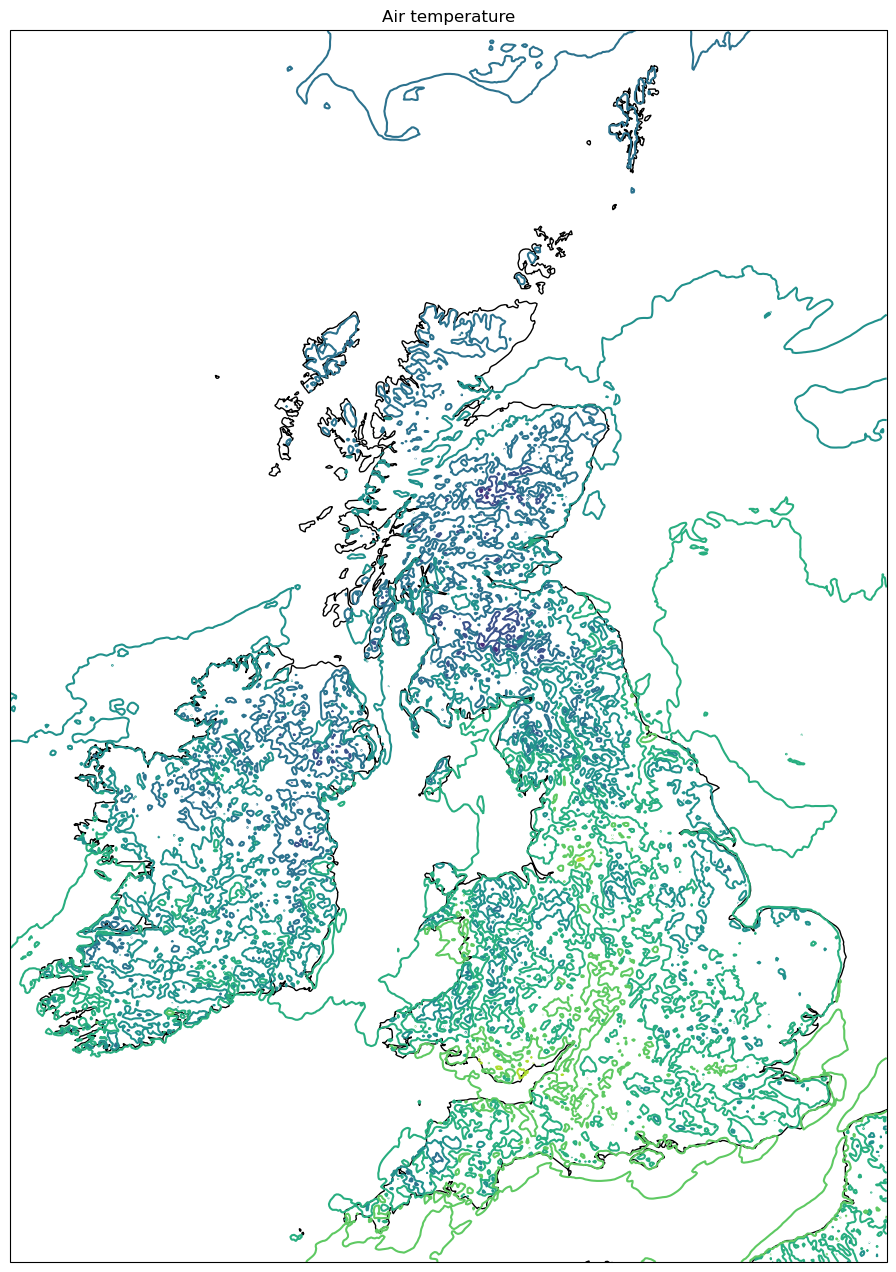

In [21]:
# show contour instead of contourf with iris
plt.figure(figsize=(16, 16))
qplt.contour(cube)
plt.gca().coastlines()
plt.show()

### Multi level Temperature Data

#### Load and Show Data

Multi level data is divided into multiple files, in the case of this order, one file for each height level, so all of the files must be loaded in and concatenated for a single cube. Luckily iris does this automatically when provided with a list of all files in one load statement.

In [22]:
# get file paths for multi level data
path_pattern_string = (
    "downloaded/"
    + multi_level_temperature_order_example_folder
    + "_"
    + order_time_selection
    + "/*.grib2"
)
downloaded_path = glob.glob(path_pattern_string)
print(downloaded_path)

['downloaded/o093919734016_00/agl_temperature_4000_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_250_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_100_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_50_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_10_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_1000_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_2000_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_500_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_3000_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_5000_+00.grib2', 'downloaded/o093919734016_00/agl_temperature_6000_+00.grib2']


In [23]:
# load the paths in iris
all_data = iris.load_cubes(downloaded_path)
single_data = iris.load_cubes(downloaded_path[0])

In [24]:
# the first and only cube in the produced iris cubelist will be the cube containing temperature data
all_data = all_data[0]  # convert cubelist to single cube
all_data

<iris 'Cube' of air_temperature / (K) (height: 11; time: 89; latitude: 24; longitude: 39)>

In [25]:
# do the same air temperature selection for the single level data
single_data = single_data[0]
single_data

<iris 'Cube' of air_temperature / (K) (time: 89; latitude: 24; longitude: 39)>

In [26]:
# get the coordinates in data for longitude and latitude
# data is the same for either cubelist
data_lat_values = single_data.coord("latitude").points
data_lon_values = single_data.coord("longitude").points
print("Lats:", data_lat_values)
print("Lons:", data_lon_values)

Lats: [49.453125 49.546875 49.640625 49.734375 49.828125 49.921875 50.015625
 50.109375 50.203125 50.296875 50.390625 50.484375 50.578125 50.671875
 50.765625 50.859375 50.953125 51.046875 51.140625 51.234375 51.328125
 51.421875 51.515625 51.609375]
Lons: [354.023438 354.164063 354.304688 354.445313 354.585938 354.726563
 354.867188 355.007813 355.148438 355.289063 355.429688 355.570313
 355.710938 355.851563 355.992188 356.132813 356.273438 356.414063
 356.554688 356.695313 356.835938 356.976563 357.117188 357.257813
 357.398438 357.539063 357.679688 357.820313 357.960938 358.101563
 358.242188 358.382813 358.523438 358.664063 358.804688 358.945313
 359.085938 359.226563 359.367188]


Files are seperated by height, and contain the selected area + another dimension for time

#### Single Layer Plot From Multi Level Data

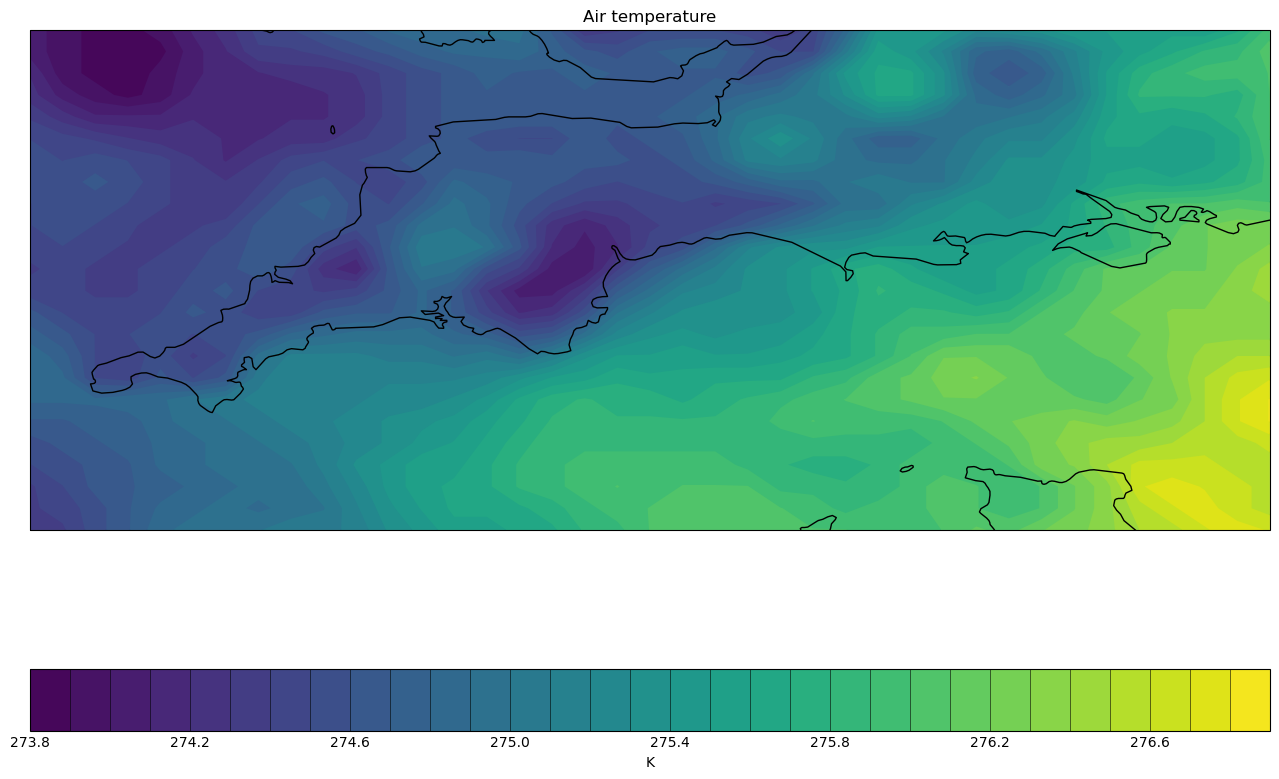

In [27]:
# single data can be treated just like our single layer data example, show a plot to example this
plt.figure(figsize=(16, 12))
# index like an array, get the first time value (since time is the first dimension in the dimension order)
qplt.contourf(single_data[0], levels=30)
plt.gca().coastlines()

plt.show()

#### Conversion of Units with Iris

Unit data: K


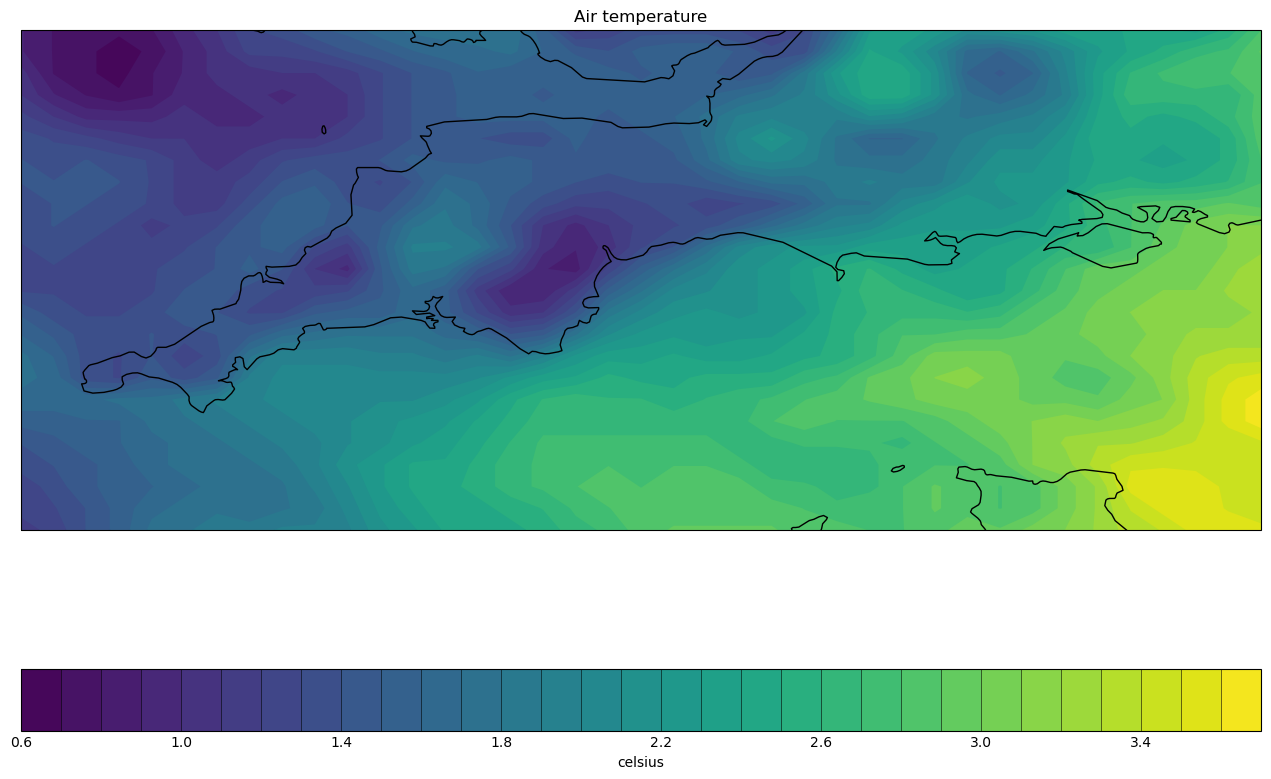

In [28]:
# iris supports conversion of units, replot with converted units (no change on plot except units on colorbar)
print("Unit data:", single_data.units)
cube_as_celcius = single_data
cube_as_celcius.convert_units(
    "celsius"
)  # iris conversion function, celcius and kelvin are known units
plt.figure(figsize=(16, 12))
qplt.contourf(cube_as_celcius[0], levels=30)
plt.gca().coastlines()

#### Plotted Example of Desired vs Actual Closest Datapoint

Closest lat val produced by model: 50.671875 vs desired: 50.716667


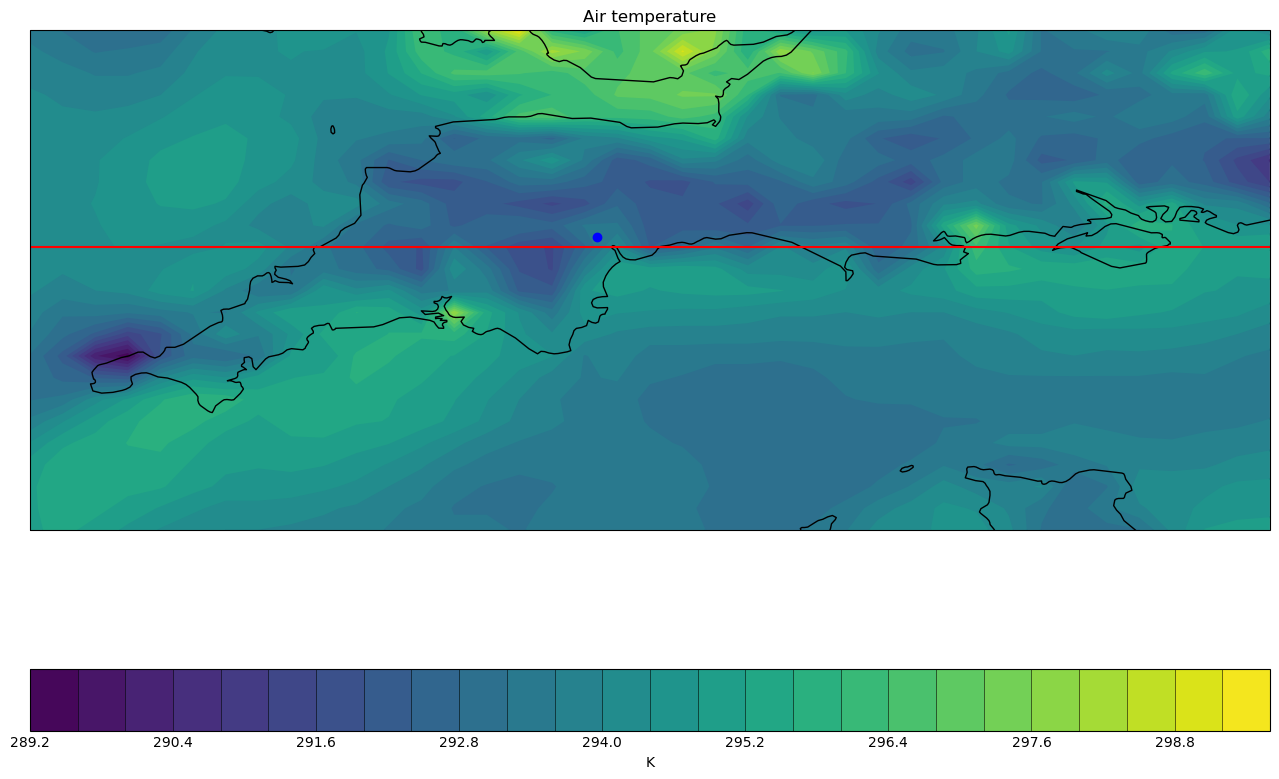

In [29]:
# show the same plot, but show a line of desired and actual latitude for later height profile
# to demonstrate the desired exact location typically doesn't exist at exactly a datapoint on the grid

multi_layer_cube_time_0_height_0 = all_data.extract(
    iris.Constraint(forecast_period=0)
).extract(iris.Constraint(height=np.min(all_data.coord("height").points)))

plt.figure(figsize=(16, 12))
# index like an array, first time value
qplt.contourf(multi_layer_cube_time_0_height_0, levels=30)
plt.gca().coastlines()

desired_lat = 50.716667
desired_lon = -3.533342
# somehow on, the longitude doesn't have negative vals, so wrap the negative around the 360 degree
desired_lon_positive = 360 + desired_lon

# index of value closest to k in ar
index = np.abs(data_lat_values - desired_lat).argmin()
# closest value
closest_lat_val = data_lat_values[index]
print("Closest lat val produced by model:", closest_lat_val, "vs desired:", desired_lat)

plt.axhline(y=closest_lat_val, color="r", linestyle="-")
plt.plot(desired_lon, desired_lat, "bo")

plt.show()

#### Height Profile of Data at Fixed Latitude

instead of viewing the top-down view of the gridded data, we can have a look at the "height profile" of the data. This will be done by plotting the height against the longitude with a fixed latitude

In [30]:
# get the height profile at the previously plotted top-down red line
cube_sliced_by_time = all_data.slices(["height", "latitude", "longitude"])
cube_at_time_0 = cube_sliced_by_time.next()
print("cube at time 0:", cube_at_time_0)
# get the height profile with lat fixed near 50.716667 (EXETER)
height_profile_of_cube = cube_at_time_0.extract(
    iris.Constraint(latitude=closest_lat_val)
)

cube at time 0: air_temperature / (K)               (height: 11; latitude: 24; longitude: 39)
    Dimension coordinates:
        height                             x             -              -
        latitude                           -             x              -
        longitude                          -             -              x
    Scalar coordinates:
        forecast_period             0 hours
        forecast_reference_time     2022-08-12 00:00:00
        time                        2022-08-12 00:00:00
    Attributes:
        GRIB_PARAM                  GRIB2:d000c000n000


In [31]:
# print the metadata of lat fixed cube
print(height_profile_of_cube)

air_temperature / (K)               (height: 11; longitude: 39)
    Dimension coordinates:
        height                             x              -
        longitude                          -              x
    Scalar coordinates:
        forecast_period             0 hours
        forecast_reference_time     2022-08-12 00:00:00
        latitude                    50.671875 degrees
        time                        2022-08-12 00:00:00
    Attributes:
        GRIB_PARAM                  GRIB2:d000c000n000


In [32]:
# give a temperature column of the closet model height column that we can (setup by showing this line on the height profile)
index = np.abs(data_lon_values - desired_lon_positive).argmin()
# closest value
closest_lon_val = data_lon_values[index]
print(
    "Closest lat val produced by model:",
    closest_lon_val,
    "vs desired:",
    desired_lon_positive,
)

Closest lat val produced by model: 356.414063 vs desired: 356.466658


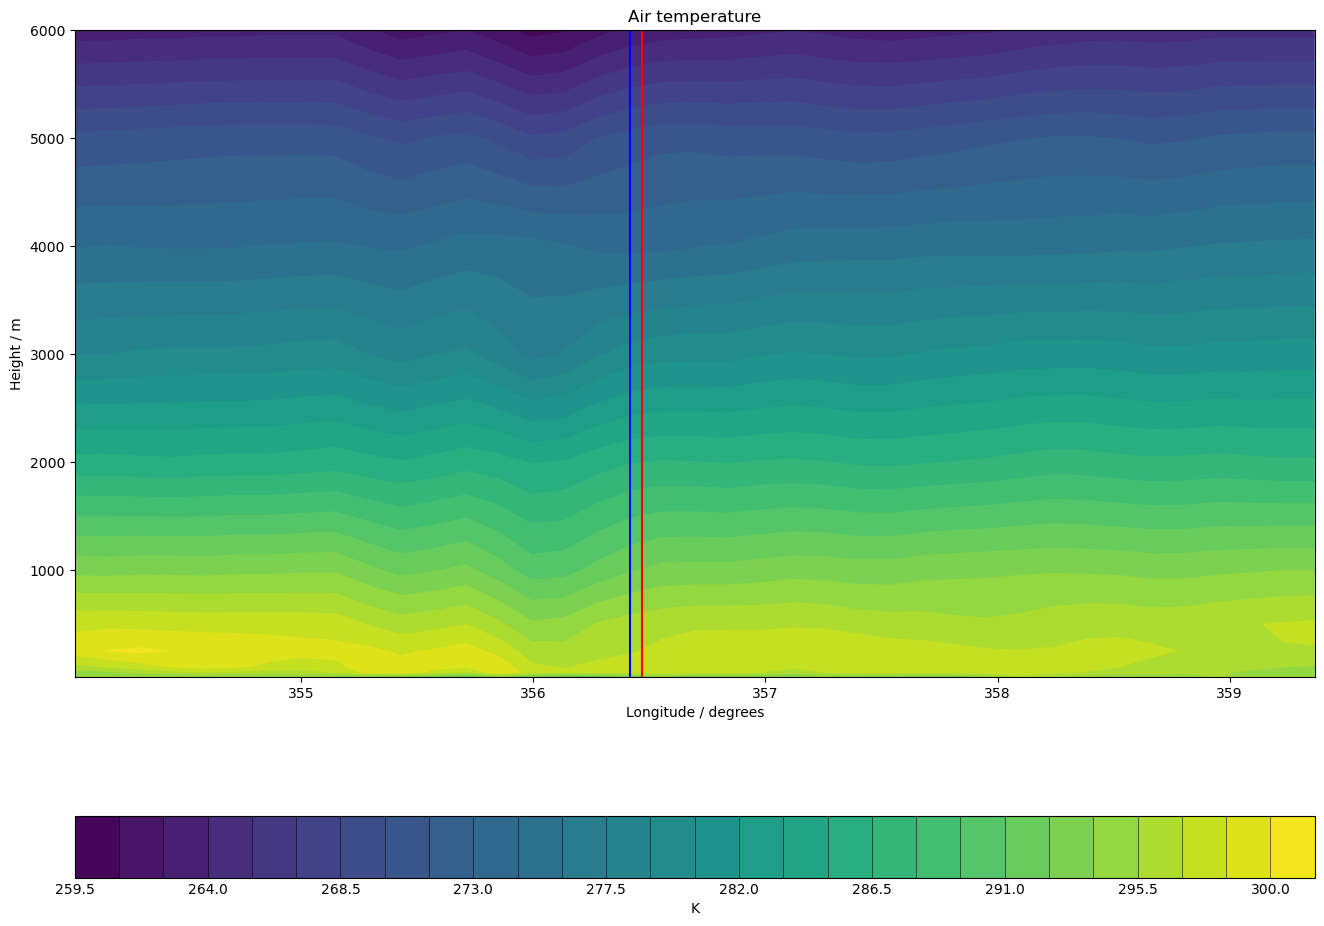

In [33]:
# plot out height cube with desired longitude and closest actual longitude
plt.figure(figsize=(16, 12))
# height profile of that red line
qplt.contourf(height_profile_of_cube, levels=30)

plt.axvline(x=desired_lon_positive, color="r", linestyle="-")  # exeter line again
# closest actual value in data
plt.axvline(x=closest_lon_val, color="b", linestyle="-")
plt.show()

#### Plot of Actual Datapoint in Gridded Data

##### Height Profile

Existing heights: [  10.   50.  100.  250.  500. 1000. 2000. 3000. 4000. 5000. 6000.]
Existing longitudes: [354.023438 354.164063 354.304688 354.445313 354.585938 354.726563
 354.867188 355.007813 355.148438 355.289063 355.429688 355.570313
 355.710938 355.851563 355.992188 356.132813 356.273438 356.414063
 356.554688 356.695313 356.835938 356.976563 357.117188 357.257813
 357.398438 357.539063 357.679688 357.820313 357.960938 358.101563
 358.242188 358.382813 358.523438 358.664063 358.804688 358.945313
 359.085938 359.226563 359.367188]


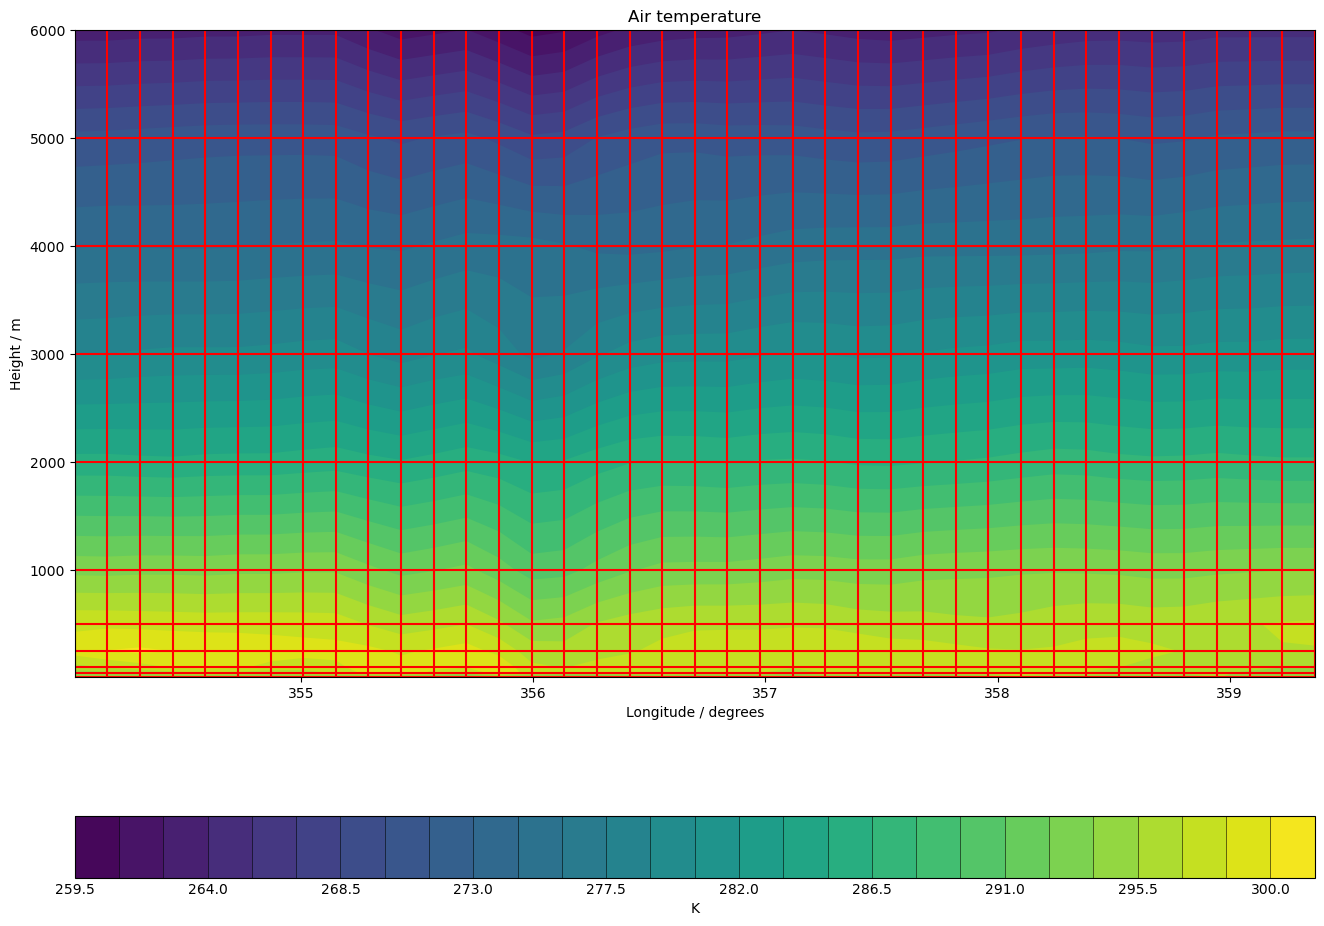

In [34]:
# show all of the actual data points that exist in the height profile
heights = height_profile_of_cube.coord("height").points
longs = height_profile_of_cube.coord("longitude").points

print("Existing heights:", heights)
print("Existing longitudes:", longs)

plt.figure(figsize=(16, 12))
qplt.contourf(height_profile_of_cube, levels=30)
for i in range(len(heights)):
    plt.axhline(y=heights[i], color="r", linestyle="-")
for i in range(len(longs)):
    plt.axvline(x=longs[i], color="r", linestyle="-")

plt.show()

##### Topdown Grid Showing

Negative longs: [-5.976562 -5.835937 -5.695312 -5.554687 -5.414062 -5.273437 -5.132812
 -4.992187 -4.851562 -4.710937 -4.570312 -4.429687 -4.289062 -4.148437
 -4.007812 -3.867187 -3.726562 -3.585937 -3.445312 -3.304687 -3.164062
 -3.023437 -2.882812 -2.742187 -2.601562 -2.460937 -2.320312 -2.179687
 -2.039062 -1.898437 -1.757812 -1.617187 -1.476562 -1.335937 -1.195312
 -1.054687 -0.914062 -0.773437 -0.632812]


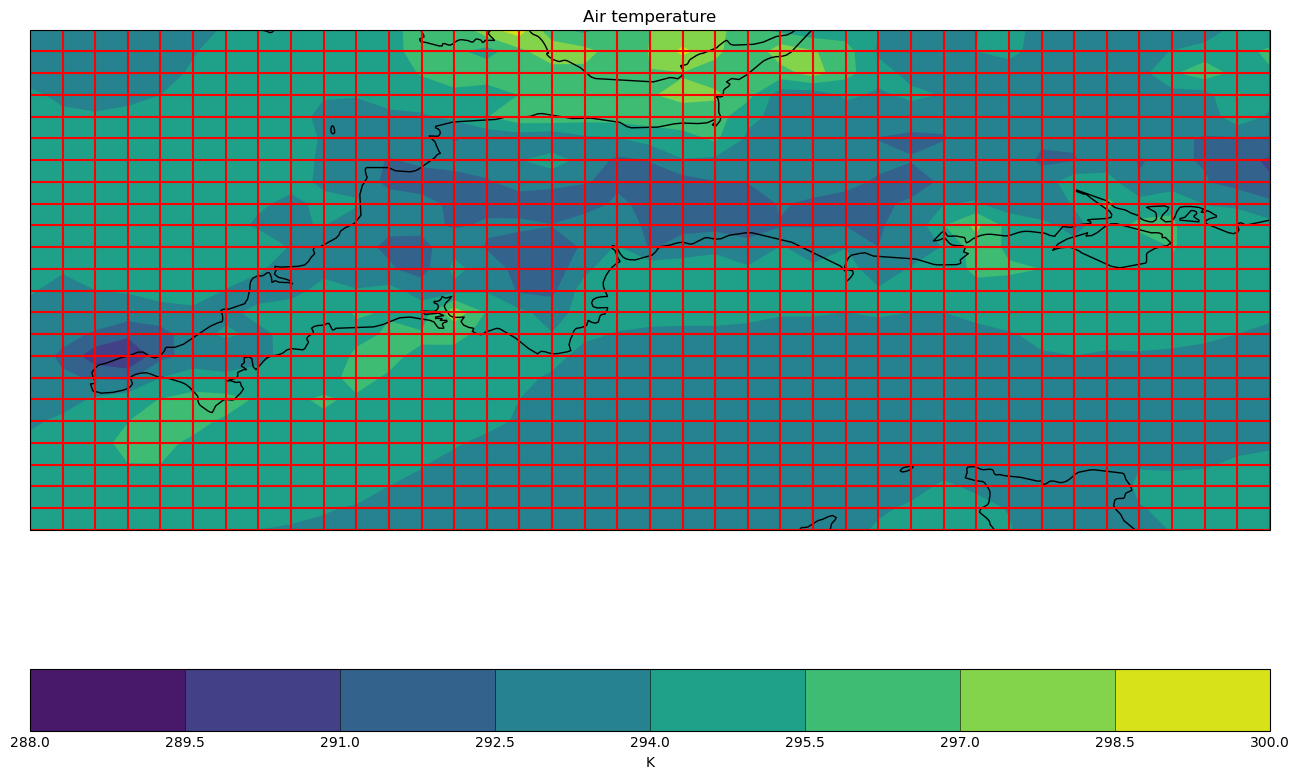

In [35]:
# do the same actual datapoint display for a top-down profile
lats = multi_layer_cube_time_0_height_0.coord("latitude").points
longs = multi_layer_cube_time_0_height_0.coord("longitude").points
longs_negative = np.add(-360, longs)  # idk why
print("Negative longs:", longs_negative)
plt.figure(figsize=(16, 12))
qplt.contourf(multi_layer_cube_time_0_height_0)
plt.gca().coastlines()
for i in range(len(lats)):
    plt.axhline(y=lats[i], color="r", linestyle="-")
for i in range(len(longs_negative)):
    plt.axvline(x=longs_negative[i], color="r", linestyle="-")
plt.show()

#### Show of Temperature at a Single Datapoint (Temperature Column)

Something you might want to do is view the temperature as the height increase, we can slice a cube at a specific lon and lat to achieve this

In [36]:
# get closest datapoint to desired longitude, show the metadata of such a cube (red line on earlier height profile)
height_column = height_profile_of_cube.extract(
    iris.Constraint(longitude=closest_lon_val)
)
height_column

<iris 'Cube' of air_temperature / (K) (height: 11)>

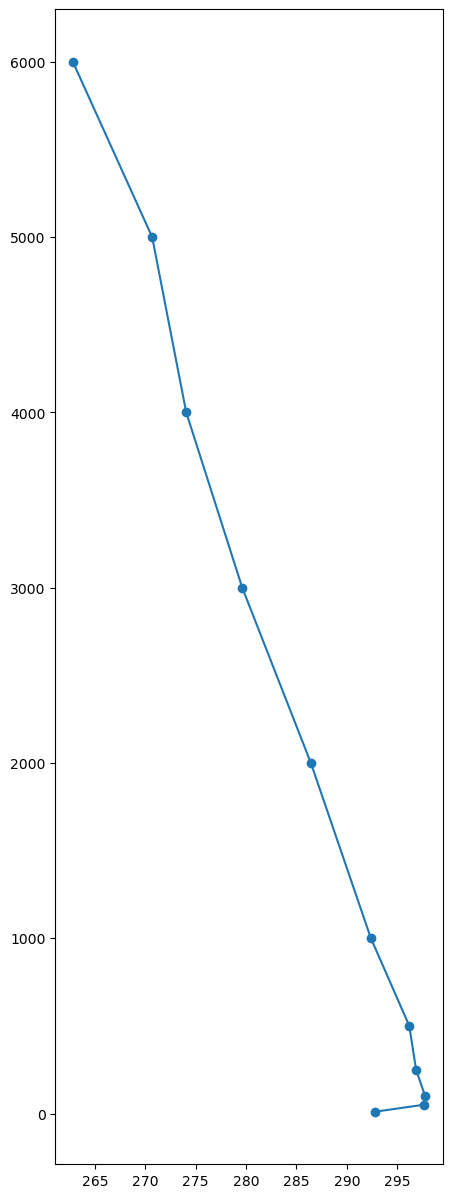

In [37]:
# plot the found temperature column
y_vals = height_column.coord("height").points
x_vals = height_column.data

fig, ax = plt.subplots(figsize=(5, 15))
ax.plot(x_vals, y_vals)
ax.scatter(x_vals, y_vals)  # also show individual points
plt.show()

### Site Specific Data Exploration

As with the previous API, to get the data, headers must be defined and given as a request to DataHub, before `cda_download.py` handled the usage of the requests package, though since the site specific data get is far less complex, interfacing with another helper file would not abstract enough of the request process for much value. The main difference is the parameters given to the https GET request that were automatically produced in the cda_downloads helper file automatically using the order information; in the site specific case, the provided parameters are the lon and lat for the desired site along with options for the returned data.

In [38]:
# hourly site specific cooridnate specifications, along with request headers
ex_lat = 50.716667
ex_lon = -3.533333

spot_data_headers = {
    "X-IBM-Client-Id": SITE_ID,
    "X-IBM-Client-Secret": SITE_SECRET,
}

params = {
    "includeLocationName": "true",
    "latitude": str(ex_lat),
    "longitude": str(ex_lon),
}

In [39]:
# request the data
request_url = "https://api-metoffice.apiconnect.ibmcloud.com/v0/forecasts/point/hourly"
request = requests.get(request_url, params=params, headers=spot_data_headers)
# insert this here otherwise IPython displays the headers of the get request
print("Request performed")

Request performed


In [40]:
# show the returned json content
content = request.json()
if SHOW_SITE_JSON_REQUEST_DATA:
    # output of this line is very large
    print("Response content:\n", json.dumps(content, indent=4))

#### Getting the Data From the Request

In order to decide how to get the data from a returned request, it is possible to either parse the API documentation on the DataHub website, or parse the actual returned JSON content (which can be optionally shown in the cell just above, with the notebook setting definition, though the output is quite large). The majority of exploration through a JSON objected involves specifying values to select specific dictionaries with keys, or list indices.

In [41]:
# get the data we want from the request return
content_forecasts = content["features"][0]["properties"]["timeSeries"]
# print(content_forecasts)

feels_like_temps = [data["feelsLikeTemperature"] for data in content_forecasts]
actual_temps = [data["screenTemperature"] for data in content_forecasts]
times = [data["time"] for data in content_forecasts]
# print(feels_like_temps)
# print(times)

#### Plot the extracted data

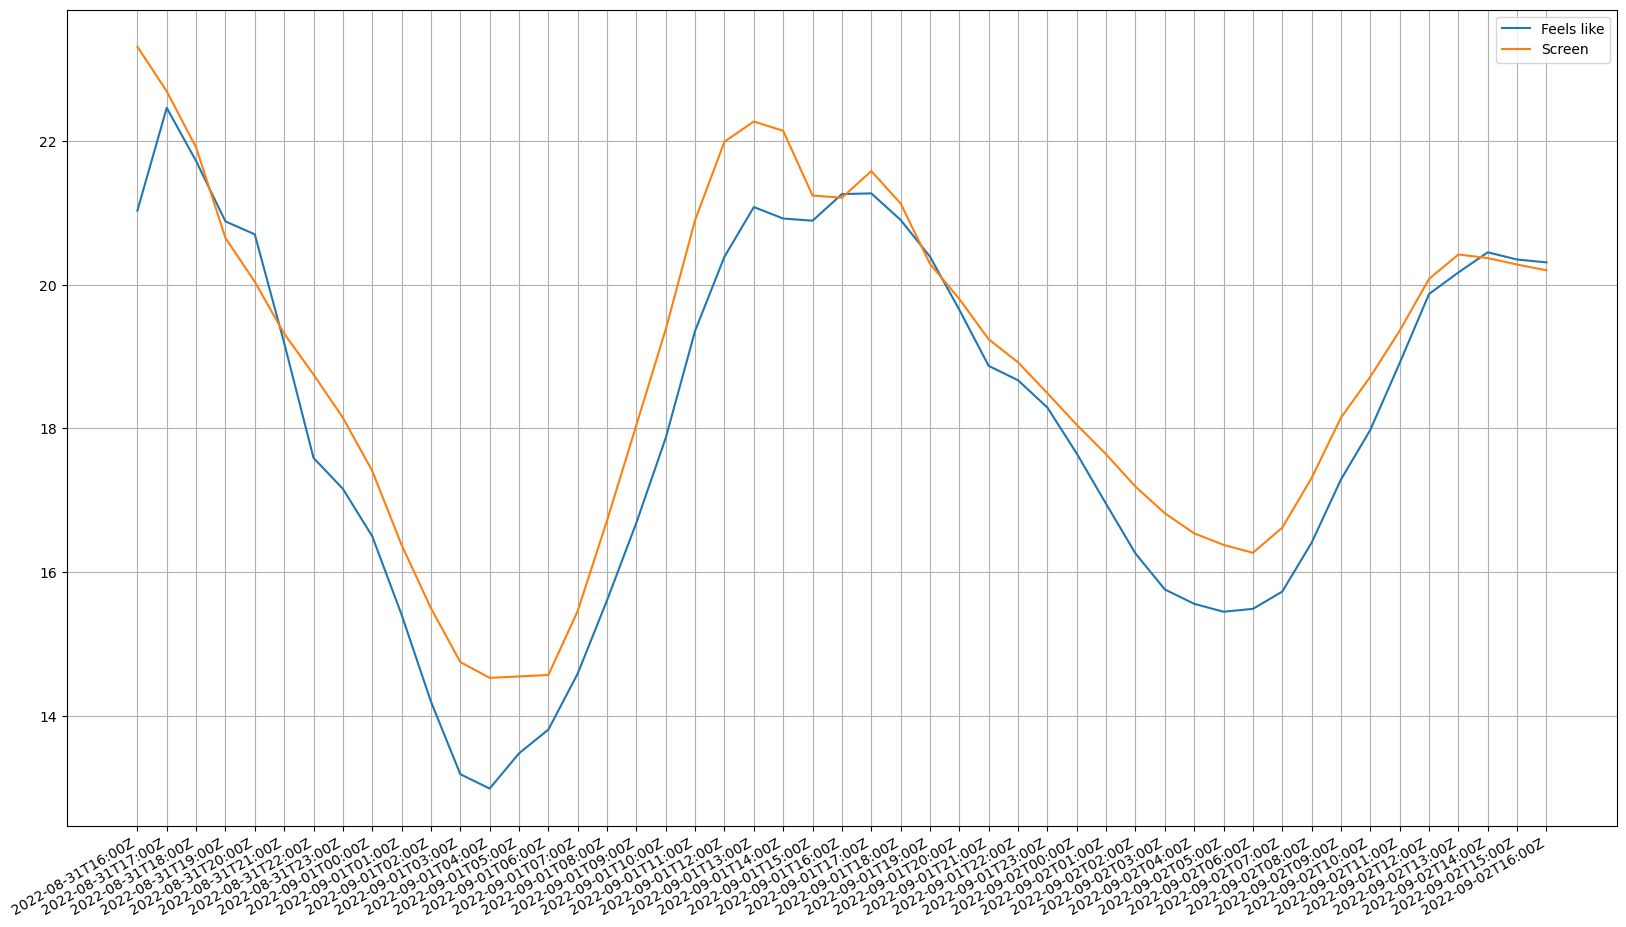

In [42]:
# plot the found data
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(times, feels_like_temps, label="Feels like")
ax.plot(times, actual_temps, label="Screen")
fig.autofmt_xdate()
plt.legend()
plt.grid()
plt.show()

## Site specific observational data from WOW

### 2021 Whole year, Single Site

#### Load in Pre-Downloaded Data

In [43]:
# define download paths for single site data
download_dir = "WOW_data"
glob_pattern = download_dir + "/*2021*.csv"
csv_files = glob.glob(glob_pattern)
print(csv_files)

['WOW_data/North_Wyke_Aug_2021_airtemp.csv', 'WOW_data/North_Wyke_Apr_2021_airtemp.csv', 'WOW_data/North_Wyke_Dec_2021_airtemp.csv', 'WOW_data/North_Wyke_Sep_2021_airtemp.csv', 'WOW_data/North_Wyke_Feb_2021_airtemp.csv', 'WOW_data/North_Wyke_Jul_2021_airtemp.csv', 'WOW_data/North_Wyke_Jan_2021_airtemp.csv', 'WOW_data/North_Wyke_Jun_2021_airtemp.csv', 'WOW_data/North_Wyke_Mar_2021_airtemp.csv', 'WOW_data/North_Wyke_May_2021_airtemp.csv', 'WOW_data/North_Wyke_Nov_2021_airtemp.csv', 'WOW_data/North_Wyke_Oct_2021_airtemp.csv']


In [44]:
# load and save data to a list per file
list_of_dfs_from_csv = []
for csv_path in csv_files:
    df = pd.read_csv(csv_path)
    list_of_dfs_from_csv.append(df)

In [45]:
# show file number
print(len(list_of_dfs_from_csv))

12


In [46]:
# concatenate all data and display the resulting dataframe
df = pd.concat(list_of_dfs_from_csv)
df

Id    Site Id  Longitude  Latitude  \
0    ﻿2021080191oaxcz1che6zq16yyb96spury  927706001       -3.9    50.767   
1     20210801b8aeitx1pye6zq16yyb96spury  927706001       -3.9    50.767   
2     20210801m3ua6q91qye6zq16yyb96spury  927706001       -3.9    50.767   
3     20210801aym1db81xye6zq16yyb96spury  927706001       -3.9    50.767   
4     20210801r8w4pz91ore6zq16yyb96spury  927706001       -3.9    50.767   
..                                   ...        ...        ...       ...   
587   2021103198inwc34oye63e9qyyb96sc5ar  927706001       -3.9    50.767   
588   20211031k4jccq34tre63e9qyyb96sc5ar  927706001       -3.9    50.767   
589   20211031zqpd1y341re63e9qyyb96sc5ar  927706001       -3.9    50.767   
590   20211031nwuafu34uee63e9qyyb96sc5ar  927706001       -3.9    50.767   
591   20211031hbq44y34iee63e9qyyb96sc5ar  927706001       -3.9    50.767   

      Report Date / Time  Air Temperature  Wet Bulb  Dew Point  \
0             2021-08-01             13.7       NaN       12.9   
1    2021-08-01 01:00:00             13.8       NaN       13.0   
2    2021-08-01 02:00:00             13.6       NaN       12.9   
3    2021-08-01 03:00:00             12.9       NaN       12.3   
4    2021-08-01 04:00:00             13.1       NaN       12.7   
..                   ...              ...       ...        ...   
587  2021-10-31 19:00:00              8.3       NaN        6.7   
588  2021-10-31 20:00:00              8.0       NaN        5.4   
589  2021-10-31 21:00:00              8.2       NaN        6.6   
590  2021-10-31 22:00:00              8.6       NaN        6.6   
591  2021-10-31 23:00:00              8.8       NaN        6.3   

     Concrete Temp.  Grass Temp.  ...  v1_Coastal  v1_Flood  v1_Ice  \
0               NaN          NaN  ...         NaN       NaN     NaN   
1               NaN          NaN  ...         NaN       NaN     NaN   
2               NaN          NaN  ...         NaN       NaN     NaN   
3               NaN          NaN  ...         NaN       NaN     NaN   
4               NaN          NaN  ...         NaN       NaN     NaN   
..              ...          ...  ...         ...       ...     ...   
587             NaN          NaN  ...         NaN       NaN     NaN   
588             NaN          NaN  ...         NaN       NaN     NaN   
589             NaN          NaN  ...         NaN       NaN     NaN   
590             NaN          NaN  ...         NaN       NaN     NaN   
591             NaN          NaN  ...         NaN       NaN     NaN   

     v1_Landslide  v1_Lightning  v1_PoorVisibility  v1_Snow  v1_Wildfire  \
0             NaN           NaN                NaN      NaN          NaN   
1             NaN           NaN                NaN      NaN          NaN   
2             NaN           NaN                NaN      NaN          NaN   
3             NaN           NaN                NaN      NaN          NaN   
4             NaN           NaN                NaN      NaN          NaN   
..            ...           ...                ...      ...          ...   
587           NaN           NaN                NaN      NaN          NaN   
588           NaN           NaN                NaN      NaN          NaN   
589           NaN           NaN                NaN      NaN          NaN   
590           NaN           NaN                NaN      NaN          NaN   
591           NaN           NaN                NaN      NaN          NaN   

     v1_Wind  v1_Other  
0        NaN       NaN  
1        NaN       NaN  
2        NaN       NaN  
3        NaN       NaN  
4        NaN       NaN  
..       ...       ...  
587      NaN       NaN  
588      NaN       NaN  
589      NaN       NaN  
590      NaN       NaN  
591      NaN       NaN  

[8126 rows x 60 columns]

#### Format and Explore the Data

In [47]:
# drop columns where all values are NaN
df.dropna(axis=1, how="all", inplace=True)
df

Id    Site Id  Longitude  Latitude  \
0    ﻿2021080191oaxcz1che6zq16yyb96spury  927706001       -3.9    50.767   
1     20210801b8aeitx1pye6zq16yyb96spury  927706001       -3.9    50.767   
2     20210801m3ua6q91qye6zq16yyb96spury  927706001       -3.9    50.767   
3     20210801aym1db81xye6zq16yyb96spury  927706001       -3.9    50.767   
4     20210801r8w4pz91ore6zq16yyb96spury  927706001       -3.9    50.767   
..                                   ...        ...        ...       ...   
587   2021103198inwc34oye63e9qyyb96sc5ar  927706001       -3.9    50.767   
588   20211031k4jccq34tre63e9qyyb96sc5ar  927706001       -3.9    50.767   
589   20211031zqpd1y341re63e9qyyb96sc5ar  927706001       -3.9    50.767   
590   20211031nwuafu34uee63e9qyyb96sc5ar  927706001       -3.9    50.767   
591   20211031hbq44y34iee63e9qyyb96sc5ar  927706001       -3.9    50.767   

      Report Date / Time  Air Temperature  Dew Point  Mean Sea-Level Pressure  \
0             2021-08-01             13.7       12.9                   1011.0   
1    2021-08-01 01:00:00             13.8       13.0                   1011.0   
2    2021-08-01 02:00:00             13.6       12.9                   1010.0   
3    2021-08-01 03:00:00             12.9       12.3                   1010.0   
4    2021-08-01 04:00:00             13.1       12.7                   1010.0   
..                   ...              ...        ...                      ...   
587  2021-10-31 19:00:00              8.3        6.7                    991.0   
588  2021-10-31 20:00:00              8.0        5.4                    992.0   
589  2021-10-31 21:00:00              8.2        6.6                    992.0   
590  2021-10-31 22:00:00              8.6        6.6                    991.0   
591  2021-10-31 23:00:00              8.8        6.3                    992.0   

     Relative Humidity  Wind Speed  Wind Direction  Wind Gust  Visibility  
0                 94.9         5.2           292.5        NaN         8.0  
1                 94.9         6.1           270.0        NaN         8.0  
2                 95.5         7.0           270.0        NaN         8.0  
3                 96.2         5.2           270.0        NaN         7.0  
4                 97.4         5.2           270.0        NaN         7.0  
..                 ...         ...             ...        ...         ...  
587               89.7        18.2           247.5       31.3         8.0  
588               83.7        20.9           247.5       29.5         8.0  
589               89.6        16.5           247.5       31.3         7.0  
590               87.2        19.1           247.5       28.7         7.0  
591               84.3        19.1           247.5       27.8         7.0  

[8126 rows x 13 columns]

In [48]:
# count NaN values in remaining columns
df.isna().sum()

Id                            0
Site Id                       0
Longitude                     0
Latitude                      0
Report Date / Time            0
Air Temperature              66
Dew Point                    66
Mean Sea-Level Pressure     295
Relative Humidity            66
Wind Speed                 1118
Wind Direction             1118
Wind Gust                  7390
Visibility                    2
dtype: int64

In [49]:
# subset the data to desired columns for exploration
df = df[["Id", "Report Date / Time", "Air Temperature"]]

In [50]:
# show subset
df

Id   Report Date / Time  Air Temperature
0    ﻿2021080191oaxcz1che6zq16yyb96spury           2021-08-01             13.7
1     20210801b8aeitx1pye6zq16yyb96spury  2021-08-01 01:00:00             13.8
2     20210801m3ua6q91qye6zq16yyb96spury  2021-08-01 02:00:00             13.6
3     20210801aym1db81xye6zq16yyb96spury  2021-08-01 03:00:00             12.9
4     20210801r8w4pz91ore6zq16yyb96spury  2021-08-01 04:00:00             13.1
..                                   ...                  ...              ...
587   2021103198inwc34oye63e9qyyb96sc5ar  2021-10-31 19:00:00              8.3
588   20211031k4jccq34tre63e9qyyb96sc5ar  2021-10-31 20:00:00              8.0
589   20211031zqpd1y341re63e9qyyb96sc5ar  2021-10-31 21:00:00              8.2
590   20211031nwuafu34uee63e9qyyb96sc5ar  2021-10-31 22:00:00              8.6
591   20211031hbq44y34iee63e9qyyb96sc5ar  2021-10-31 23:00:00              8.8

[8126 rows x 3 columns]

In [51]:
# drop ROWS with NaN values
df = df.dropna(axis=0)
df

Id   Report Date / Time  Air Temperature
0    ﻿2021080191oaxcz1che6zq16yyb96spury           2021-08-01             13.7
1     20210801b8aeitx1pye6zq16yyb96spury  2021-08-01 01:00:00             13.8
2     20210801m3ua6q91qye6zq16yyb96spury  2021-08-01 02:00:00             13.6
3     20210801aym1db81xye6zq16yyb96spury  2021-08-01 03:00:00             12.9
4     20210801r8w4pz91ore6zq16yyb96spury  2021-08-01 04:00:00             13.1
..                                   ...                  ...              ...
587   2021103198inwc34oye63e9qyyb96sc5ar  2021-10-31 19:00:00              8.3
588   20211031k4jccq34tre63e9qyyb96sc5ar  2021-10-31 20:00:00              8.0
589   20211031zqpd1y341re63e9qyyb96sc5ar  2021-10-31 21:00:00              8.2
590   20211031nwuafu34uee63e9qyyb96sc5ar  2021-10-31 22:00:00              8.6
591   20211031hbq44y34iee63e9qyyb96sc5ar  2021-10-31 23:00:00              8.8

[8060 rows x 3 columns]

In [52]:
# print dataframe (df) length and drop the duplicates, print length of dropped duplicates to show none exist (lengths are equal)
print(len(df))
print(len(df.drop_duplicates()))

8060
8060


#### Show Data Issue: Missing Observations

In [53]:
# count observations for each day, show amount of missing data
expected_observations = 365 * 24  # every day in the year, for 24 hours
print("Expected obs:", expected_observations)

dates_in_df = df["Report Date / Time"].str[0:10]  # yyyy-mm-dd = length 10
df_for_dates = df.copy()
df_for_dates["Report Date / Time"] = dates_in_df
df_for_dates.drop("Air Temperature", axis=1, inplace=True)

date_counter = (
    df_for_dates.groupby("Report Date / Time").count().sort_values(by="Id")
)  # yyyy-mm-dd = length 10

print("counts of observations given on dates:\n", date_counter, "\n")
print("Expected days:", 365)
print("Actual days:", len(date_counter))
print("Missing days:", (365 - len(date_counter)))
print(
    "Existing days with missing data:",
    len(date_counter[date_counter < 24].dropna(axis=0)),
)

Expected obs: 8760
counts of observations given on dates:
                     Id
Report Date / Time    
2021-10-13           2
2021-02-06           7
2021-10-15           7
2021-02-14           9
2021-03-11           9
...                 ..
2021-05-20          24
2021-05-19          24
2021-05-18          24
2021-05-16          24
2021-07-07          24

[349 rows x 1 columns] 

Expected days: 365
Actual days: 349
Missing days: 16
Existing days with missing data: 100


In [54]:
# sort data by time
df = df.sort_values("Report Date / Time")
df.head(25)

Id   Report Date / Time  Air Temperature
0   ﻿20210101xc6kffkm3ye6zd9pyyb96spf9y           2021-01-01             -2.2
1    202101015iwnnm1m4ye6zd9pyyb96spf9y  2021-01-01 01:00:00             -3.1
2    2021010184hssk1m5re6zd9pyyb96spf9y  2021-01-01 02:00:00             -4.1
3    20210101wnhdxd1mhre6zd9pyyb96spf9y  2021-01-01 03:00:00             -2.2
4    20210101yjkyq9nm7ee6zd9pyyb96spf9y  2021-01-01 04:00:00             -1.0
5    20210101as5u5cnm9ee6zd9pyyb96spf9y  2021-01-01 05:00:00             -2.0
6    20210101fs7bxhkcyce6zd9pyyb96spf9y  2021-01-01 06:00:00             -2.8
7    20210101tguprx4cbce6zd9pyyb96spf9y  2021-01-01 07:00:00             -2.2
8    202101016rqre41cnce6zd9pyyb96spf9y  2021-01-01 08:00:00             -1.7
9    2021010169r5soncnce6zd9pyyb96spf9y  2021-01-01 09:00:00             -1.8
10   20210101juqk384cdoe6zd9pyyb96spf9y  2021-01-01 10:00:00             -1.3
11   20210101i456fu4croe6zd9pyyb96spf9y  2021-01-01 11:00:00              0.0
12   20210101nb14iancfwe6zd9pyyb96spf9y  2021-01-01 12:00:00              0.4
13   20210101qeoqyzncgwe6zd9pyyb96spf9y  2021-01-01 13:00:00              1.7
14   202101014owg4wnc8we6zd9pyyb96spf9y  2021-01-01 14:00:00              2.0
15   20210101gzr4j6nceae6zd9pyyb96spf9y  2021-01-01 15:00:00              1.8
16   202101019r5zkp4ckae6zd9pyyb96spf9y  2021-01-01 16:00:00              1.8
17   20210101mcqxc91cmhe6zd9pyyb96spf9y  2021-01-01 17:00:00              1.7
18   20210101c6qwirkcmhe6zd9pyyb96spf9y  2021-01-01 18:00:00              2.0
19   20210101dh8zak4cqye6zd9pyyb96spf9y  2021-01-01 19:00:00              2.2
20   20210101obghyf1cxye6zd9pyyb96spf9y  2021-01-01 20:00:00              2.0
21   20210101hecczukcoye6zd9pyyb96spf9y  2021-01-01 21:00:00              2.1
22   202101017iufbn4coye6zd9pyyb96spf9y  2021-01-01 22:00:00              2.1
23   20210101etjuqhkctre6zd9pyyb96spf9y  2021-01-01 23:00:00              2.0
24  ﻿20210102wscebukc1re6zd9pyyb96spf9y           2021-01-02              1.9

In [55]:
# check air temperature is a number instead of string
print(df["Air Temperature"].dtype)

float64


#### Plot of Average Temperatures with Rolling Mean

This implementation is notably incorrect for the earlier issue has not been amended. A rolling mean for a week might span 9 actual days if 2 days of observations out of the 7 days from the start of the rolling mean are missing.

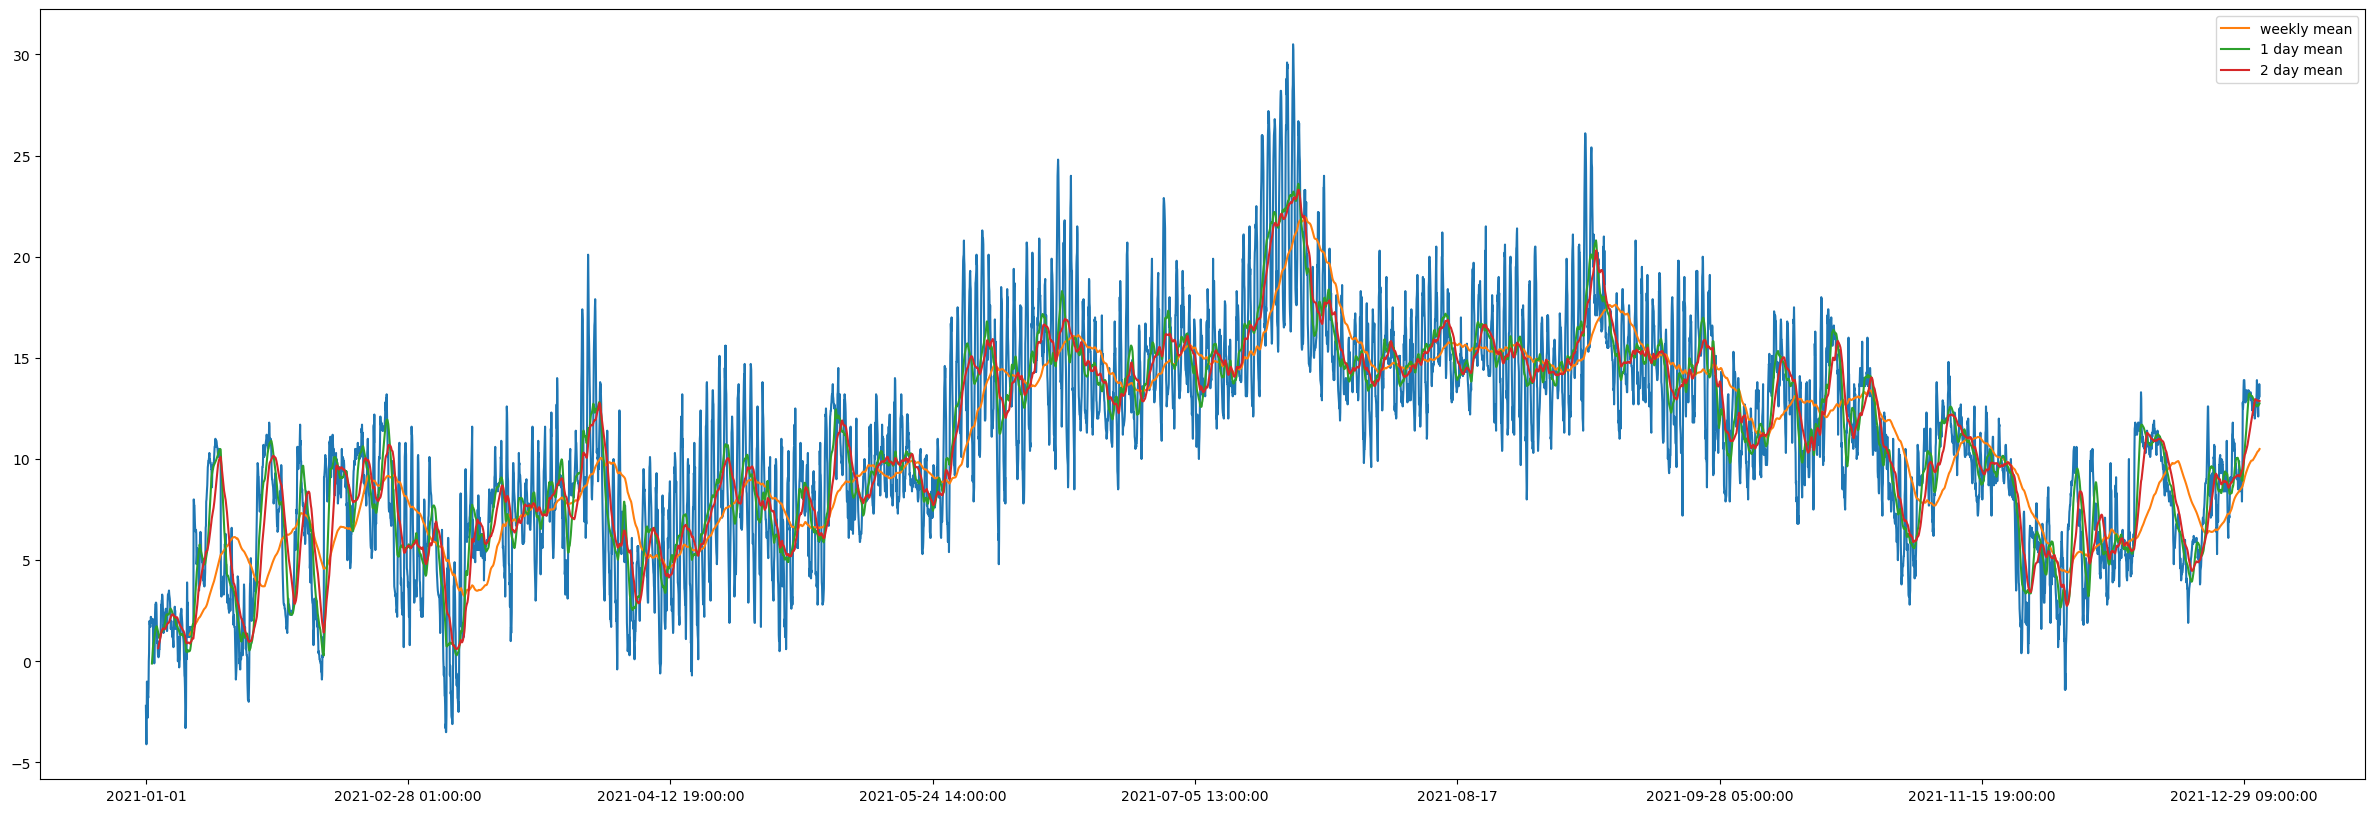

In [56]:
# plot single site data with different rolling means to make better sense of temperatures across longer timescales
plt.figure(figsize=(30, 10))
plt.plot(df["Report Date / Time"], df["Air Temperature"])
# 168 = 24*7 = approx the weekly average temp (inaccurate due to missing data)
plt.plot(
    df["Report Date / Time"],
    df["Air Temperature"].rolling(168).mean(),
    label="weekly mean",
)
# similarly 24 is a 1 day mean (due to the expted observation frequency of 1 hour)
plt.plot(
    df["Report Date / Time"],
    df["Air Temperature"].rolling(24).mean(),
    label="1 day mean",
)
plt.plot(
    df["Report Date / Time"],
    df["Air Temperature"].rolling(48).mean(),
    label="2 day mean",
)
number_of_samples = len(df["Report Date / Time"])
plt.xticks(np.arange(0, number_of_samples, 1000))
plt.legend()
# plt.yticks([])

### Wow data, 2019 Seasonal, 5 sites across England

#### Load and Merge Data into Singular DataFrame

In [57]:
# define filepaths for multiple site data (in this case data taken from 2019 is multi site)
download_dir = "WOW_data"
glob_pattern = download_dir + "/*2019*.csv"
csv_files = glob.glob(glob_pattern)
print(csv_files)

['WOW_data/WOW_Yeovilton_2019_OCT.csv', 'WOW_data/WOW_Leek_2019_JUL.csv', 'WOW_data/WOW_Andrewsfield_2019_APR.csv', 'WOW_data/WOW_Andrewsfield_2019_JAN.csv', 'WOW_data/WOW_Andrewsfield_2019_JUL.csv', 'WOW_data/WOW_Andrewsfield_2019_OCT.csv', 'WOW_data/WOW_Leconfield-Sar_2019_APR.csv', 'WOW_data/WOW_Leconfield-Sar_2019_JAN.csv', 'WOW_data/WOW_Leconfield-Sar_2019_JUL.csv', 'WOW_data/WOW_Leconfield-Sar_2019_OCT.csv', 'WOW_data/WOW_Leek_2019_APR.csv', 'WOW_data/WOW_Leek_2019_JAN.csv', 'WOW_data/WOW_Leek_2019_OCT.csv', 'WOW_data/WOW_Spadeadam_2019_APR.csv', 'WOW_data/WOW_Spadeadam_2019_JAN.csv', 'WOW_data/WOW_Spadeadam_2019_JUL.csv', 'WOW_data/WOW_Spadeadam_2019_OCT.csv', 'WOW_data/WOW_Yeovilton_2019_APR.csv', 'WOW_data/WOW_Yeovilton_2019_JAN.csv', 'WOW_data/WOW_Yeovilton_2019_JUL.csv', 'WOW_data/WOW_Church-Lawford_2019_OCT.csv', 'WOW_data/WOW_Church-Lawford_2019_APR.csv', 'WOW_data/WOW_Church-Lawford_2019_JAN.csv', 'WOW_data/WOW_Church-Lawford_2019_JUL.csv']


In [58]:
# read and save data into dfs
list_of_dfs_from_csv = []
for csv_path in csv_files:
    df = pd.read_csv(csv_path)
    list_of_dfs_from_csv.append(df)

In [59]:
# show files loaded
print(len(list_of_dfs_from_csv))

24


In [60]:
# bring all data into a single dataframe
df = pd.concat(list_of_dfs_from_csv)
df

Id  Site Id  Longitude  Latitude  \
0    ﻿201910019qk1oo9d7ee6uc73yyb96scsqc     1040      -2.64    51.006   
1     20191001yescfaxd7ce6uc73yyb96scsqc     1040      -2.64    51.006   
2     20191001mip663xd6ce6uc73yyb96scsqc     1040      -2.64    51.006   
3     20191001rdtwm6xryoe6uc73yyb96scsqc     1040      -2.64    51.006   
4     20191001okthjexrboe6uc73yyb96scsqc     1040      -2.64    51.006   
..                                   ...      ...        ...       ...   
713   201907311zb3sq7u3re6ucrryyb96scn6y     7007      -1.33    52.358   
714   20190731mfdyojiu5ee6ucrryyb96scn6y     7007      -1.33    52.358   
715   20190731zcmcrxiuhee6ucrryyb96scn6y     7007      -1.33    52.358   
716   20190731duifdriu7ce6ucrryyb96scn6y     7007      -1.33    52.358   
717   20190731x4q1fxpu6ce6ucrryyb96scn6y     7007      -1.33    52.358   

      Report Date / Time  Air Temperature  Wet Bulb  Dew Point  \
0             2019-10-01             15.3       NaN       13.9   
1    2019-10-01 01:00:00             14.6       NaN       13.4   
2    2019-10-01 02:00:00             15.1       NaN       13.8   
3    2019-10-01 03:00:00             15.1       NaN       13.8   
4    2019-10-01 04:00:00             15.4       NaN       14.1   
..                   ...              ...       ...        ...   
713  2019-07-31 19:00:00             17.8       NaN       13.1   
714  2019-07-31 20:00:00             16.9       NaN       13.2   
715  2019-07-31 21:00:00             16.6       NaN       13.4   
716  2019-07-31 22:00:00             16.2       NaN       13.5   
717  2019-07-31 23:00:00             15.9       NaN       13.5   

     Concrete Temp.  Grass Temp.  ...  v1_Coastal  v1_Flood  v1_Ice  \
0               NaN          NaN  ...         NaN       NaN     NaN   
1               NaN          NaN  ...         NaN       NaN     NaN   
2               NaN          NaN  ...         NaN       NaN     NaN   
3               NaN          NaN  ...         NaN       NaN     NaN   
4               NaN          NaN  ...         NaN       NaN     NaN   
..              ...          ...  ...         ...       ...     ...   
713             NaN          NaN  ...         NaN       NaN     NaN   
714             NaN          NaN  ...         NaN       NaN     NaN   
715             NaN          NaN  ...         NaN       NaN     NaN   
716             NaN          NaN  ...         NaN       NaN     NaN   
717             NaN          NaN  ...         NaN       NaN     NaN   

     v1_Landslide  v1_Lightning  v1_PoorVisibility  v1_Snow  v1_Wildfire  \
0             NaN           NaN                NaN      NaN          NaN   
1             NaN           NaN                NaN      NaN          NaN   
2             NaN           NaN                NaN      NaN          NaN   
3             NaN           NaN                NaN      NaN          NaN   
4             NaN           NaN                NaN      NaN          NaN   
..            ...           ...                ...      ...          ...   
713           NaN           NaN                NaN      NaN          NaN   
714           NaN           NaN                NaN      NaN          NaN   
715           NaN           NaN                NaN      NaN          NaN   
716           NaN           NaN                NaN      NaN          NaN   
717           NaN           NaN                NaN      NaN          NaN   

     v1_Wind  v1_Other  
0        NaN       NaN  
1        NaN       NaN  
2        NaN       NaN  
3        NaN       NaN  
4        NaN       NaN  
..       ...       ...  
713      NaN       NaN  
714      NaN       NaN  
715      NaN       NaN  
716      NaN       NaN  
717      NaN       NaN  

[16719 rows x 60 columns]

##### Ensure no Duplicate Data has been Loaded (Manual Verification Through Cell Output)

In [61]:
# show duplicate rows, should be none
df[df.duplicated()]

Empty DataFrame
Columns: [Id, Site Id, Longitude, Latitude, Report Date / Time, Air Temperature, Wet Bulb, Dew Point, Concrete Temp., Grass Temp., Min. Temp. (last 24hr), Max. Temp. (last 24hr), Soil Temp. (at 10cm), Soil Temp. (at 30cm), Soil Temp. (at 100cm), Mean Sea-Level Pressure, Pressure (At Station), Relative Humidity, Rainfall Rate, Rainfall Accumulation, Wind Speed, Wind Direction, Wind Gust, Wind Gust Direction, Snow Depth, Soil Moisture, Present Weather, Visibility, Total Cloud Cover, Sunshine, Ground State, Day of Thunder, Day of Gales, Day of Hail, Day of Snow, Weather Diary, Travel Disruption, Hazards causing Travel Disruption, Property or Infrastructure Damage, Hazards causing Property or Infrastructure Damage, Personal Health and Safety, Hazards causing Personal Health and Safety, Utility Disruption, Hazards causing Utility Disruption, Service or Business Disruption, Hazards causing Service or Business Disruption, Agriculture Habitat Damage, Hazards causing Agriculture Habitat Damage, Disruption to Camping Events Leisure Activities, Hazards causing Disruption to Camping Events Leisure Activities, v1_Coastal, v1_Flood, v1_Ice, v1_Landslide, v1_Lightning, v1_PoorVisibility, v1_Snow, v1_Wildfire, v1_Wind, v1_Other]
Index: []

[0 rows x 60 columns]

#### Plot Multi Site Information

In [62]:
# show the unique lon lat combinations to get the positions of unique sites
lat_lon_df = df[["Longitude", "Latitude"]]
lat_lon_df = lat_lon_df.drop_duplicates()
lat_lon_df

Longitude  Latitude
0   -2.64000  51.00600
0   -1.97993  53.12755
0    0.45300  51.89600
0   -0.43300  53.86700
0   -2.55300  55.05000
0   -1.33000  52.35800

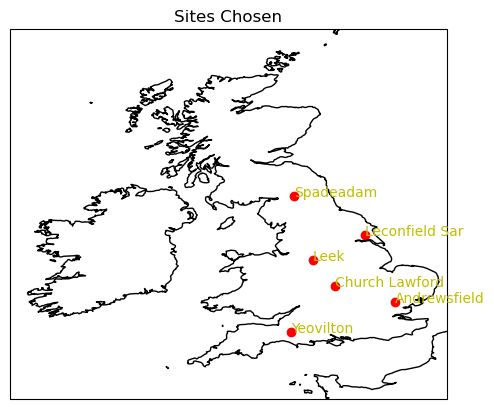

In [63]:
# plot and annotate the site positions on a map, this wastes DataHub requests on just site names.
# save the site names to a list
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title("Sites Chosen")
ax.set_extent([-11, 2, 60, 49], ccrs.PlateCarree())  # extent is uk
plt.scatter(x=lat_lon_df["Longitude"], y=lat_lon_df["Latitude"], color="r")
ax.coastlines()

# possible to integrate this with met office datahub api to get location names (not obs site names)
name_list = []
for i, (df_ind, (lon, lat)) in enumerate(lat_lon_df.iterrows()):
    params = {
        "includeLocationName": "true",
        "latitude": str(lat),
        "longitude": str(lon),
    }
    # optionally 'waste' datahub site specific requests by getting #
    request = requests.get(request_url, params=params, headers=spot_data_headers)
    # the site names for each location ignoring the forecast data returned  #
    name = request.json()["features"][0]["properties"]["location"]["name"]
    name_list.append((name, lon, lat))
    plt.annotate(name, (lon, lat), c="y")

plt.show()

#### Prune and Format Data to Desired Data for Plotting

In [64]:
# do some data processing, drop columns with all NaNs
df.dropna(axis=1, how="all", inplace=True)
# take all rows where air temp is reported
df = df[df["Air Temperature"].notna()]
df

Id  Site Id  Longitude  Latitude  \
0    ﻿201910019qk1oo9d7ee6uc73yyb96scsqc     1040      -2.64    51.006   
1     20191001yescfaxd7ce6uc73yyb96scsqc     1040      -2.64    51.006   
2     20191001mip663xd6ce6uc73yyb96scsqc     1040      -2.64    51.006   
3     20191001rdtwm6xryoe6uc73yyb96scsqc     1040      -2.64    51.006   
4     20191001okthjexrboe6uc73yyb96scsqc     1040      -2.64    51.006   
..                                   ...      ...        ...       ...   
713   201907311zb3sq7u3re6ucrryyb96scn6y     7007      -1.33    52.358   
714   20190731mfdyojiu5ee6ucrryyb96scn6y     7007      -1.33    52.358   
715   20190731zcmcrxiuhee6ucrryyb96scn6y     7007      -1.33    52.358   
716   20190731duifdriu7ce6ucrryyb96scn6y     7007      -1.33    52.358   
717   20190731x4q1fxpu6ce6ucrryyb96scn6y     7007      -1.33    52.358   

      Report Date / Time  Air Temperature  Dew Point  Mean Sea-Level Pressure  \
0             2019-10-01             15.3       13.9                   1002.0   
1    2019-10-01 01:00:00             14.6       13.4                   1001.0   
2    2019-10-01 02:00:00             15.1       13.8                   1000.0   
3    2019-10-01 03:00:00             15.1       13.8                    999.0   
4    2019-10-01 04:00:00             15.4       14.1                    998.0   
..                   ...              ...        ...                      ...   
713  2019-07-31 19:00:00             17.8       13.1                   1013.0   
714  2019-07-31 20:00:00             16.9       13.2                   1014.0   
715  2019-07-31 21:00:00             16.6       13.4                   1014.0   
716  2019-07-31 22:00:00             16.2       13.5                   1015.0   
717  2019-07-31 23:00:00             15.9       13.5                   1015.0   

     Relative Humidity  Wind Speed  Wind Direction  Wind Gust Visibility  
0                 91.3         7.0           202.5        NaN          7  
1                 92.5         6.1           180.0        NaN          7  
2                 91.9         5.2           180.0        NaN          7  
3                 91.9         4.3           202.5        NaN          7  
4                 92.0         6.1           202.5        NaN          7  
..                 ...         ...             ...        ...        ...  
713               73.8         8.7           270.0        NaN          9  
714               78.7         7.0           270.0        NaN          9  
715               81.3         6.1           270.0        NaN          9  
716               83.9         7.0           270.0        NaN          8  
717               85.6         5.2           270.0        NaN          9  

[16603 rows x 13 columns]

In [65]:
# add hour minute seconds to data that is missing this information (only at midnight)
# standardize the times (add HH:MM:SS time to days at midnight)
df["Report Date / Time"] = df["Report Date / Time"].apply(
    lambda x: (x + " 00:00:00") if len(x) == 10 else x
)
df

/var/tmp/ipykernel_32992/888559346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Report Date / Time"] = df["Report Date / Time"].apply(


Id  Site Id  Longitude  Latitude  \
0    ﻿201910019qk1oo9d7ee6uc73yyb96scsqc     1040      -2.64    51.006   
1     20191001yescfaxd7ce6uc73yyb96scsqc     1040      -2.64    51.006   
2     20191001mip663xd6ce6uc73yyb96scsqc     1040      -2.64    51.006   
3     20191001rdtwm6xryoe6uc73yyb96scsqc     1040      -2.64    51.006   
4     20191001okthjexrboe6uc73yyb96scsqc     1040      -2.64    51.006   
..                                   ...      ...        ...       ...   
713   201907311zb3sq7u3re6ucrryyb96scn6y     7007      -1.33    52.358   
714   20190731mfdyojiu5ee6ucrryyb96scn6y     7007      -1.33    52.358   
715   20190731zcmcrxiuhee6ucrryyb96scn6y     7007      -1.33    52.358   
716   20190731duifdriu7ce6ucrryyb96scn6y     7007      -1.33    52.358   
717   20190731x4q1fxpu6ce6ucrryyb96scn6y     7007      -1.33    52.358   

      Report Date / Time  Air Temperature  Dew Point  Mean Sea-Level Pressure  \
0    2019-10-01 00:00:00             15.3       13.9                   1002.0   
1    2019-10-01 01:00:00             14.6       13.4                   1001.0   
2    2019-10-01 02:00:00             15.1       13.8                   1000.0   
3    2019-10-01 03:00:00             15.1       13.8                    999.0   
4    2019-10-01 04:00:00             15.4       14.1                    998.0   
..                   ...              ...        ...                      ...   
713  2019-07-31 19:00:00             17.8       13.1                   1013.0   
714  2019-07-31 20:00:00             16.9       13.2                   1014.0   
715  2019-07-31 21:00:00             16.6       13.4                   1014.0   
716  2019-07-31 22:00:00             16.2       13.5                   1015.0   
717  2019-07-31 23:00:00             15.9       13.5                   1015.0   

     Relative Humidity  Wind Speed  Wind Direction  Wind Gust Visibility  
0                 91.3         7.0           202.5        NaN          7  
1                 92.5         6.1           180.0        NaN          7  
2                 91.9         5.2           180.0        NaN          7  
3                 91.9         4.3           202.5        NaN          7  
4                 92.0         6.1           202.5        NaN          7  
..                 ...         ...             ...        ...        ...  
713               73.8         8.7           270.0        NaN          9  
714               78.7         7.0           270.0        NaN          9  
715               81.3         6.1           270.0        NaN          9  
716               83.9         7.0           270.0        NaN          8  
717               85.6         5.2           270.0        NaN          9  

[16603 rows x 13 columns]

In [66]:
# convert data/time string to Date Time python object
str_format = "%Y-%m-%d %H:%M:%S"
df["Report Date / Time"] = df["Report Date / Time"].apply(
    lambda x: datetime.datetime.strptime(x, str_format)
)
print(df["Report Date / Time"].dtype)
df

datetime64[ns]


/var/tmp/ipykernel_32992/1950089291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Report Date / Time"] = df["Report Date / Time"].apply(


Id  Site Id  Longitude  Latitude  \
0    ﻿201910019qk1oo9d7ee6uc73yyb96scsqc     1040      -2.64    51.006   
1     20191001yescfaxd7ce6uc73yyb96scsqc     1040      -2.64    51.006   
2     20191001mip663xd6ce6uc73yyb96scsqc     1040      -2.64    51.006   
3     20191001rdtwm6xryoe6uc73yyb96scsqc     1040      -2.64    51.006   
4     20191001okthjexrboe6uc73yyb96scsqc     1040      -2.64    51.006   
..                                   ...      ...        ...       ...   
713   201907311zb3sq7u3re6ucrryyb96scn6y     7007      -1.33    52.358   
714   20190731mfdyojiu5ee6ucrryyb96scn6y     7007      -1.33    52.358   
715   20190731zcmcrxiuhee6ucrryyb96scn6y     7007      -1.33    52.358   
716   20190731duifdriu7ce6ucrryyb96scn6y     7007      -1.33    52.358   
717   20190731x4q1fxpu6ce6ucrryyb96scn6y     7007      -1.33    52.358   

     Report Date / Time  Air Temperature  Dew Point  Mean Sea-Level Pressure  \
0   2019-10-01 00:00:00             15.3       13.9                   1002.0   
1   2019-10-01 01:00:00             14.6       13.4                   1001.0   
2   2019-10-01 02:00:00             15.1       13.8                   1000.0   
3   2019-10-01 03:00:00             15.1       13.8                    999.0   
4   2019-10-01 04:00:00             15.4       14.1                    998.0   
..                  ...              ...        ...                      ...   
713 2019-07-31 19:00:00             17.8       13.1                   1013.0   
714 2019-07-31 20:00:00             16.9       13.2                   1014.0   
715 2019-07-31 21:00:00             16.6       13.4                   1014.0   
716 2019-07-31 22:00:00             16.2       13.5                   1015.0   
717 2019-07-31 23:00:00             15.9       13.5                   1015.0   

     Relative Humidity  Wind Speed  Wind Direction  Wind Gust Visibility  
0                 91.3         7.0           202.5        NaN          7  
1                 92.5         6.1           180.0        NaN          7  
2                 91.9         5.2           180.0        NaN          7  
3                 91.9         4.3           202.5        NaN          7  
4                 92.0         6.1           202.5        NaN          7  
..                 ...         ...             ...        ...        ...  
713               73.8         8.7           270.0        NaN          9  
714               78.7         7.0           270.0        NaN          9  
715               81.3         6.1           270.0        NaN          9  
716               83.9         7.0           270.0        NaN          8  
717               85.6         5.2           270.0        NaN          9  

[16603 rows x 13 columns]

In [67]:
# take only the desired data for plots, sort data
sub_df_for_plot = df[["Site Id", "Report Date / Time", "Air Temperature"]]
sub_df_for_plot = sub_df_for_plot.sort_values(by="Report Date / Time")  # sort by date
sub_df_for_plot

Site Id  Report Date / Time  Air Temperature
0         32 2019-01-01 00:00:00              7.3
0       1040 2019-01-01 00:00:00              8.8
0       7011 2019-01-01 00:00:00              9.1
0       7001 2019-01-01 00:00:00              8.1
0       7007 2019-01-01 00:00:00              8.3
..       ...                 ...              ...
735     1040 2019-10-31 23:00:00             12.0
734     7007 2019-10-31 23:00:00              7.5
733     7001 2019-10-31 23:00:00              7.9
731     5018 2019-10-31 23:00:00              6.2
731       32 2019-10-31 23:00:00              5.1

[16603 rows x 3 columns]

In [68]:
# drop all rows with NaN values, get a seperate dataframe per site
sub_df_for_plot = sub_df_for_plot.dropna(axis=0)
plot_by_site = dict(tuple(sub_df_for_plot.groupby("Site Id")))

In [69]:
# convert the site grouped dataframes into a list
df_list = []
for values in plot_by_site.values():
    df_list.append(pd.DataFrame(values))
df_list[0]

Site Id  Report Date / Time  Air Temperature
0         32 2019-01-01 00:00:00              7.3
1         32 2019-01-01 01:00:00              7.3
2         32 2019-01-01 02:00:00              7.4
3         32 2019-01-01 03:00:00              7.5
4         32 2019-01-01 04:00:00              7.6
..       ...                 ...              ...
727       32 2019-10-31 19:00:00              5.8
728       32 2019-10-31 20:00:00              5.3
729       32 2019-10-31 21:00:00              4.9
730       32 2019-10-31 22:00:00              4.9
731       32 2019-10-31 23:00:00              5.1

[2813 rows x 3 columns]

#### Plot Desired Data as a Whole

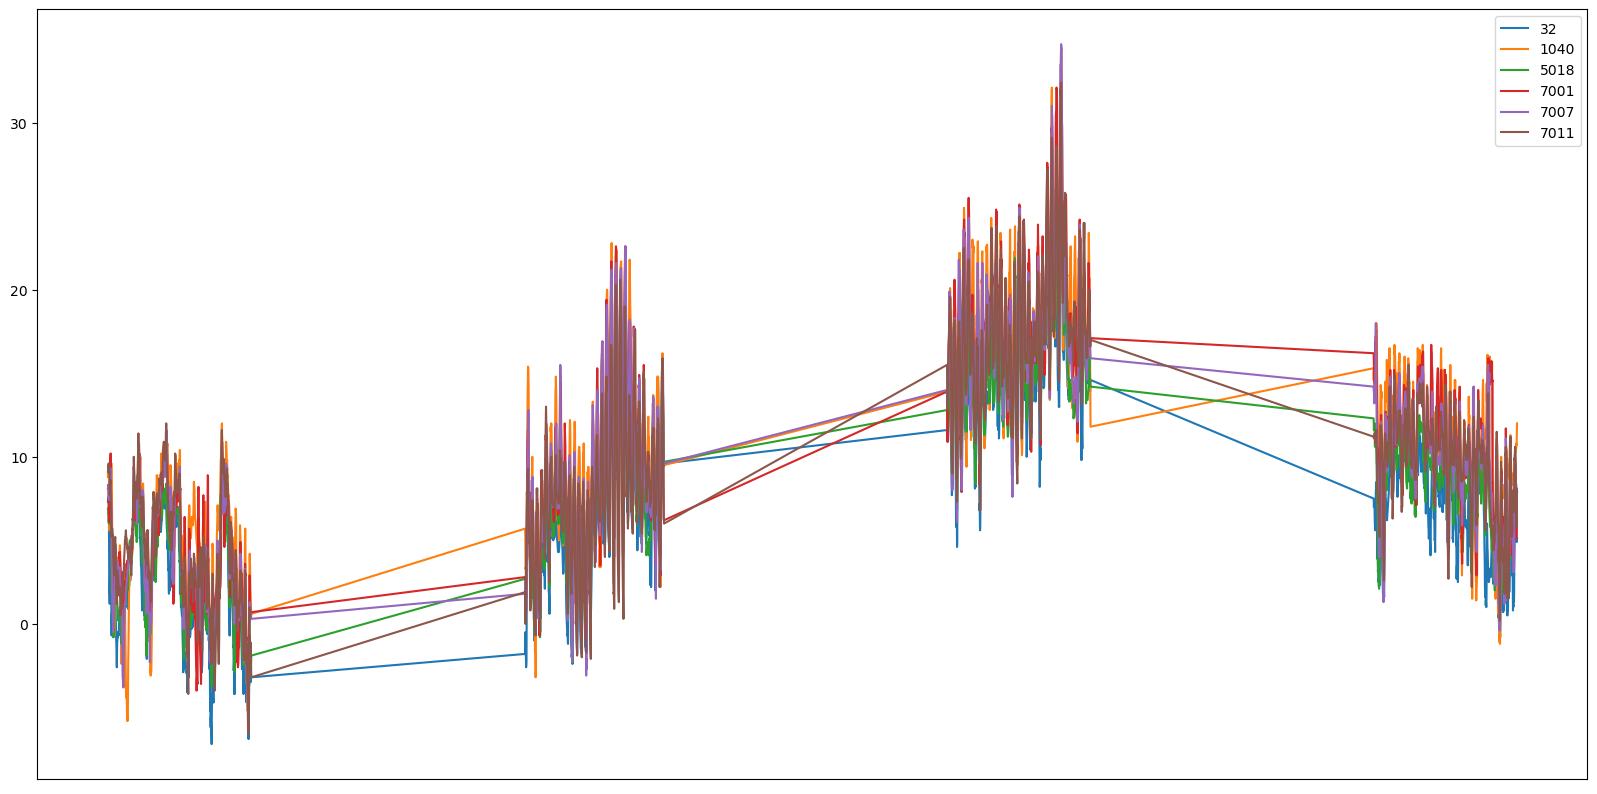

In [70]:
# plot each site into one figure
plt.figure(figsize=(20, 10))
for df in df_list:
    plt.plot(
        df["Report Date / Time"], df["Air Temperature"], label=df["Site Id"].iloc[0]
    )
plt.xticks([])
plt.legend()

#### Separate Data by Month per Site

In [71]:
# further group data by month (grouped by site first, then month)
i = 0
for site in df_list:
    site["month"] = site["Report Date / Time"].apply(lambda x: x.month)
    seasonal = dict(tuple(site.groupby("month")))
    season_list = []
    for values in seasonal.values():
        season_list.append(pd.DataFrame(values))
    df_list[i] = season_list  # dynamically typed magic, or just bad practice?
    # print(i)
    i += 1
del i

#### Plot Separated Data in Individual Figures

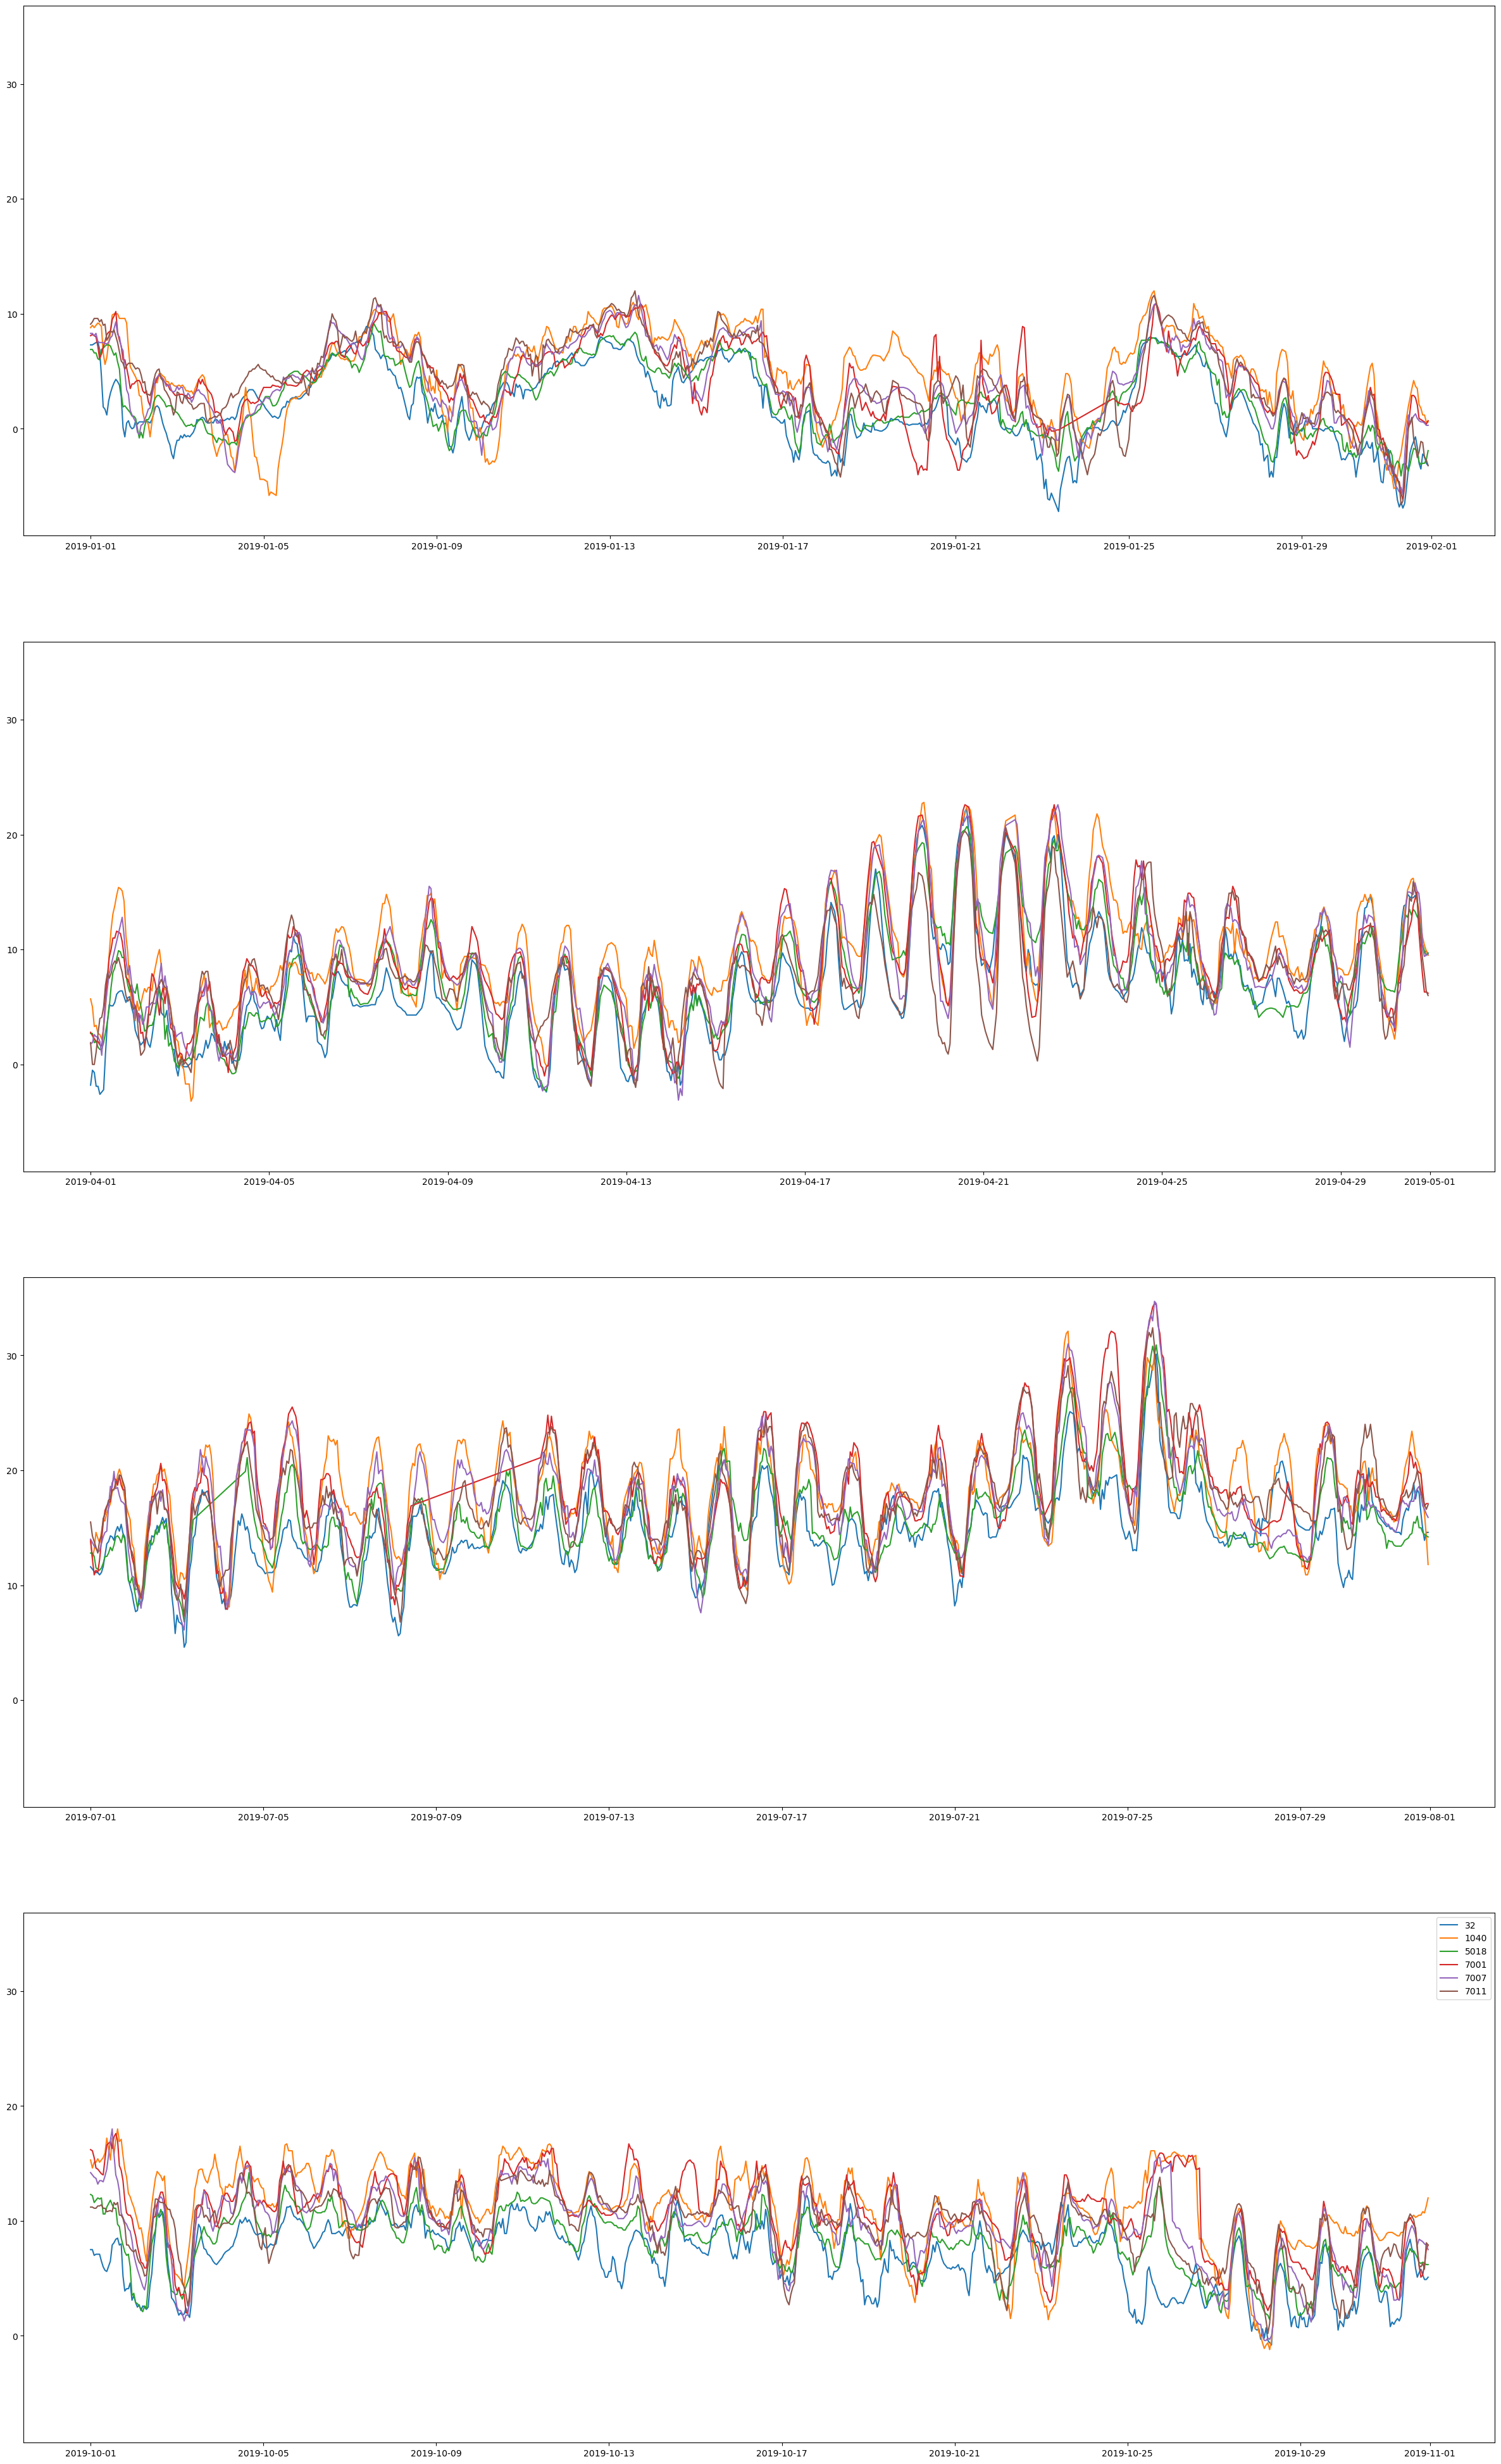

In [72]:
# plot the site, month grouping of data across month based plots
fig, axes = plt.subplots(
    nrows=len(df_list[0]), ncols=1, figsize=(30, 50), sharex=False, sharey=True
)

for i, ax in enumerate(axes.flatten()):
    for j in range(len(df_list)):
        ax.plot(
            df_list[j][i]["Report Date / Time"],
            df_list[j][i]["Air Temperature"],
            label=df_list[j][i]["Site Id"].iloc[0],
        )
plt.legend()